# Inferring cosmology power spectrum parameters from 2D fields
(by Lucas Makinen and Tom Charnock)

A useful example to consider is the inference of the parameter values controlling the shape of the power spectrum used to generate 2D Gaussian random fields. This is interesting because we can analytically calculate the Fisher information to check our convergence and it has aspects which are very similar to cosmological field analysis. This example is split into two parts, first the analytic comparison when the power spectrum is of the form 
$$P(k) = Ak^{-B}$$
and a second part where we use a jax implementation of a cosmology library (`pip install jax-cosmo`) to infer cosmological parameters from 2D Gaussian random fields. 

In this example we will also show how inception blocks can be implemented in a stax-like neural model.

## Power law example - $P(k) = Ak^{-B}$

The likelihood for an $N_{\rm pix}\times N_{\rm pix}$ Gaussian field, $\boldsymbol{\delta}$, can be explicitly written down for the Fourier transformed data, $\boldsymbol{\Delta}$ as
$$\mathcal{L}(\boldsymbol{\Delta}|\boldsymbol{\theta}) = \frac{1}{(2\pi)^{N_{\rm pix}^2 / 2} |P({\bf k}, \boldsymbol{\theta})|^{1/2}}\exp{\left(-\frac{1}{2}\boldsymbol{\Delta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\boldsymbol{\Delta}\right)}$$
Since the Fisher information can be calculated from the expectation value of the second derivative of the score, i.e. the log likelihood
$${\bf F}_{\alpha\beta} = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}(\Delta|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}=\boldsymbol{\theta}^\textrm{fid}}$$
Then we know that analytically the Fisher information must be
$${\bf F}_{\alpha\beta} = \frac{1}{2} {\rm Tr} \left(\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\alpha}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\beta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\right)$$
where $\alpha$ and $\beta$ label the parameters $A$ and $B$ in the power spectrum. As each $k$-mode is uncoupled for this power law form then the derivatives  are
$$\begin{align}
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial A} = &~k^{-B}\\
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial B} = & -Ak^{-B}\ln k.\\
\end{align}$$
We can set up these functions using `powerbox-jax`.

In [1]:
import jax
jax.__version__

'0.3.25'

In [2]:
import jax
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [3]:
# !pip install --quiet powerbox
# !pip install --quiet --no-deps git+https://github.com/tlmakinen/powerbox-jax.git

In [4]:
# !pip install -q jax-cosmo

In [3]:
rng = jax.random.PRNGKey(2)

In [4]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp
np = jnp

In [5]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp
np = jnp

#import tensorflow as tf

import powerbox_jax as pbj
import powerbox as pbox
#import imnn
#import imnn.lfi

import flax.linen as nn
import optax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt

In [6]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', False)

In [7]:
N=128
L=250.
dim=2
shape = (N,)*dim
θ_fid = np.array([1., 0.5], dtype=np.float32)

# define P(k)

In [8]:
# define power spectrum
def P(k, A=1, B=0):
    return A * k ** (-B)

In [9]:
from powerbox_jax.dft import _set_left_edge, fftfreq

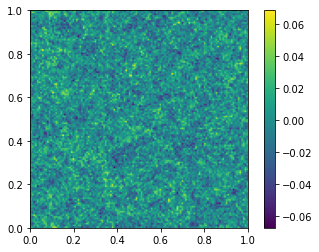

In [10]:
rng = jax.random.PRNGKey(32)

pb = pbj.PowerBox(
    N=N,                     # Number of grid-points in the box
    dim=dim,                     # 2D box
    pk = lambda k: P(k, A=0.3, B=0.8) / L, # The power-spectrum
    boxlength = L,           # Size of the box (sets the units of k in pk)
    key = rng,                # Use the same seed as our powerbox
    vol_normalised_power=True,
    supplied_freqs=None
)
plt.imshow(pb.delta_x()[:, :],extent=(0,1,0,1))
plt.colorbar()
plt.show()

### check that simulated field power and input power are the same

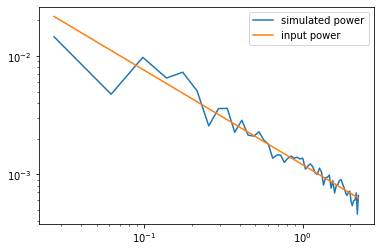

In [11]:
p_k_field, bins_field = pbox.get_power(pb.delta_x(), pb.boxlength)
plt.plot(bins_field, p_k_field, label='simulated power')
plt.plot(bins_field, P(bins_field, 0.3, 0.8) / L, label='input power')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [12]:
# helper function for pre-computing (potentially variable) frequency arrays for ffts

def get_freqs(shape, L, fourier_b=1.0):
    # set frequencies for jittable fft calculation

    axes = list(range(len(shape)))
    _N = np.array([shape[axis] for axis in axes])

    # Get the box volume if given the real-space box volume
    _L = np.array([L] * len(axes))
    dx = _L / _N
    Lk = 2 * np.pi / (dx * fourier_b)

    Lk = np.array(Lk)
    left_edge = _set_left_edge(None, axes, Lk)

    V = np.product(Lk)
    dk = np.array(Lk) / np.array(_N)

    _myfreq = lambda n,d: fftfreq(n, d=d, b=fourier_b)
    freq = jax.tree_map(_myfreq, list(_N), list(dk))
    return freq, axes, left_edge

In [13]:
simulator_args = dict(
  N=N,
  L=L,
  shape=shape,
  dim=len(shape),
  freqs=get_freqs(shape,L),# pre-compute frequencies
  vol_norm=True,           # whether to normalise P(k) by volume
  L_scale=True,            # scale P(k) by length scale
  squeeze=True)

# the field simulator

In [14]:
def simulator(rng, θ, simulator_args, foregrounds=None):
    def fn(rng, A, B):
        dim = len(simulator_args["shape"])
        L = simulator_args["L"]

        if simulator_args["L_scale"]:
          pk = lambda k: P(k, A=A, B=B) / simulator_args["L"]

        else:
          pk = lambda k: P(k, A=A, B=B)

        lnpb = pbj.LogNormalPowerBox(
            N=simulator_args["N"],         # Number of grid-points in the box
            dim=simulator_args["dim"],     # 3D box
            pk=pk,                         # The power-spectrum
            boxlength=simulator_args["L"], # Size of the box (sets the units of k in pk)
            key=rng, 
            supplied_freqs=simulator_args["freqs"]                    
        )

        field = lnpb.delta_x()
            
        if foregrounds is not None:
            rng, key = jax.random.split(key)
            foreground = foregrounds[
                jax.random.randint(
                    key, 
                    minval=0, 
                    maxval=foregrounds.shape[0], 
                    shape=())]    
            field = np.expand_dims(field + foreground, (0,))
            
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0, -1))
            
        return np.array(field, dtype='float32')

    if isinstance(θ, tuple):
        A, B = θ
    else:
        A = np.take(θ, 0, axis=-1, mode=None)
        B = np.take(θ, 1, axis=-1, mode=None)
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, B)

# compute analytic information content

In [15]:
def fisher_ln(θ, simulator_args=simulator_args):

    def Power_fn(θ):
      A,B = θ

      if simulator_args["L_scale"]:
        pk = lambda k: P(k, A=A, B=B) / simulator_args["L"]

      else:
        pk = lambda k: P(k, A=A, B=B)

      pb = pbj.PowerBox(
        N=simulator_args["N"],                     # Number of grid-points in the box
        dim=simulator_args["dim"],                 # 2D box
        pk = pk,                                   # The power-spectrum
        boxlength = simulator_args["L"],           # Size of the box (sets the units of k in pk)
        key = rng,                                 # Use the same seed as our powerbox
        vol_normalised_power=True,
        supplied_freqs=simulator_args['freqs']
      )
      return pb.power_array()
      
    # take derivatives through P_G
    C_jac = jax.jacfwd(Power_fn)(θ)

    # Now take only the unique modes in the fourier volume
    pgauss = Power_fn(θ)[:N//2 , :N].reshape(-1, 1)
    C_jac = C_jac[:N//2 , :N].reshape(pgauss.shape[0],2)

    Cinv = 1. / pgauss.flatten() #np.diag(1. / pgauss.flatten())

    C_A = C_jac.T[0].flatten() #np.diag(C_jac.T[0].flatten())
    C_B = C_jac.T[1].flatten() #np.diag(C_jac.T[1].flatten())

    F_AA = 0.5 * np.sum((Cinv * C_A * Cinv * C_A))
    F_AB = 0.5 * np.sum((Cinv * C_B * Cinv * C_A ))
    F_BA = 0.5 * np.sum((Cinv * C_A * Cinv * C_B))
    F_BB = 0.5 * np.sum((Cinv * C_B * Cinv * C_B))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

In [16]:
F = fisher_ln(θ_fid)
print(f"F = {F}")
print("det(F) = {:e}".format(np.linalg.det(F)))

F = [[4096.      -475.60403]
 [-475.60403 1091.6548 ]]
det(F) = 4.245219e+06


In [17]:
0.5*np.log(np.linalg.det(F))

DeviceArray(7.630652, dtype=float32)

# define the neural network

In [18]:
import flax.linen as nn

In [19]:
n_s = 200
n_d = n_s

n_summaries = 2
n_params = 2

In [20]:
from typing import Any, Callable, Sequence, Optional
from flax.core import freeze, unfreeze

class AsinhLayer(nn.Module):
    bias_init: Callable = nn.initializers.zeros
    a_init: Callable = nn.initializers.ones
    b_init: Callable = nn.initializers.ones
    c_init: Callable = nn.initializers.zeros
    d_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):

        a = self.param('a', self.a_init, (1,))
        b = self.param('b', self.b_init, (1,))
        c = self.param('c', self.c_init, (1,))
        d = self.param('d', self.d_init, (1,)) 

        y = a*np.arcsinh(b*inputs + c) + d
        return y

In [21]:
class InceptBlock(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    strides: int
    dims: int
    do_5x5: bool = True
    do_3x3: bool = True
    #input_shape: Sequence[int]

    @nn.compact
    def __call__(self, x):

        outs = []
        
        if self.do_5x5:
        # 5x5 filter
          x1 = nn.Conv(features=self.filters[0], kernel_size=(1,)*self.dims, strides=None)(x)
          x1 = nn.Conv(features=self.filters[0], kernel_size=(5,)*self.dims, strides=self.strides)(x1)
          outs.append(x1)
          
        if self.do_3x3:
        # 3x3 filter
          x2 = nn.Conv(features=self.filters[1], kernel_size=(1,)*self.dims, strides=None)(x)
          x2 = nn.Conv(features=self.filters[1], kernel_size=(3,)*self.dims, strides=self.strides)(x2)
          outs.append(x2)

        # 1x1
        x3 = nn.Conv(features=self.filters[2], kernel_size=(1,)*self.dims, strides=None)(x)
        x3 = nn.Conv(features=self.filters[2], kernel_size=(1,)*self.dims, strides=self.strides)(x3)
        outs.append(x3)
        
        # maxpool
        x4 = nn.max_pool(x, (3,3), padding='SAME')
        x4 = nn.Conv(features=self.filters[3], kernel_size=(1,)*self.dims, strides=self.strides)(x4)
        outs.append(x4)
                    
        x = np.concatenate(outs, axis=-1)
        
        return x     

In [22]:
filters = (33,33,33,33)

class InceptNet(nn.Module):
    """An incept net architecture"""
    
    @nn.compact
    def __call__(self, x):
        x = AsinhLayer()(x)
        x = InceptBlock(filters, strides=4, dims=2)(x)
        x = nn.gelu(x)
        x = InceptBlock(filters, strides=4, dims=2)(x)
        x = nn.gelu(x)
        x = InceptBlock(filters, strides=4, dims=2)(x)
        x = nn.gelu(x)
        x = InceptBlock(filters, strides=4, dims=2)(x)
        x = nn.gelu(x)
        x = nn.Conv(features=n_params, kernel_size=(1,)*dim, strides=None)(x)
        x = x.reshape(-1)
        return x

In [23]:
model = InceptNet()

In [24]:
input_shape = (1,) + shape + (1,)

key,rng = jax.random.split(rng)

dummy_x = np.expand_dims(simulator(rng, θ_fid, simulator_args), (0, -1))

# INITIAL PARAMS
initial_w = model.init(key, dummy_x)
# DUMMY OUTPUT
output = model.apply(initial_w, dummy_x)

In [25]:
output

DeviceArray([0.00157141, 0.00093435], dtype=float32)

# IMNN modules (also pip-installable)

In [41]:
!pip install -U -q --no-deps git+https://tlmakinen@bitbucket.org/tlmakinen/imnn.git@flax

In [26]:
import imnn
#import imnn.lfi

In [28]:
#@title utils module
def _check_input(input, shape, name, allow_None=False):
    """Exception raising checks for numpy array shapes

    Checks whether input is not ``None`` and if not checks that the input is a
    jax numpy array and if not raises a warning. If the input is a jax numpy
    array it then checks the shape is the same as the required shape.

    Can also allow ``None`` to be passed if it input is not essential.

    Parameters
    ----------
    input: any
        The input parameter to be checked
    shape: tuple
        The shape that the input is required to be
    name: str
        The name of the variable for printing explicit errors in ``Exception``
    allow_None: bool, default=False
        Whether a ``None`` input can be returned as None without raising error

    Returns
    -------
    array
        Returns the input if all checks pass

    Raises
    ------
    ValueError
        If input is None
    ValueError
        If input shape is incorrect
    TypeError
        If input is not a jax array
    """
    if (input is None) and (not allow_None):
        raise ValueError(f"`{name}` is None")
    elif (input is None) and allow_None:
        return input
    #elif not isinstance(
            #input, (type(jax.interpreters.xla.device_array), type(np.ndarray))):
        #raise TypeError(f"`{name}` must be a jax array")
    else:
        if input.shape != shape:
            raise ValueError(f"`{name}` should have shape {shape} but has " +
                             f"{input.shape}")
    return input

In [29]:
#@title imnn module
import math
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt
from functools import partial
from imnn.utils.utils import _check_boolean, _check_type, \
    _check_model, _check_model_output, _check_optimiser, _check_state, \
    _check_statistics_set
from imnn.experimental import progress_bar


class _myIMNN:
    """Information maximising neural network parent class

    This class defines the general fitting framework for information maximising
    neural networks. It includes the generic calculations of the Fisher
    information matrix from the outputs of a neural network as well as an XLA
    compilable fitting routine (with and without a progress bar). This class
    also provides a plotting routine for fitting history and a function to
    calculate the score compression of network outputs to quasi-maximum
    likelihood estimates of model parameter values.

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    simulations and :math:`n_d` derivatives with respect to physical model
    parameters are used to calculate network outputs and their derivatives
    with respect to the physical model parameters, :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha`, where
    :math:`\\alpha` labels the physical parameter. The exact details of how
    these are calculated depend on the type of available data (see list of
    different IMNN below). With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function. Note for large input data-sizes, large :math:`n_s` or massive
    networks the gradients may need manually accumulating via the
    :func:`~imnn.imnn._aggregated_imnn._AggregatedIMNN`.

    ``_IMNN`` is designed as the parent class for a range of specific case
    IMNNs. There is a helper function (IMNN) which should return the correct
    case when provided with the correct data. These different subclasses are:

    :func:`~imnn.SimulatorIMNN`:

        Fit an IMNN using simulations generated on-the-fly from a jax (XLA
        compilable) simulator

    :func:`~imnn.GradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and their
        derivatives with respect to model parameters

    :func:`~imnn.NumericalGradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and
        simulations generated using parameter values just above and below the
        fiducial parameter values to make a numerical estimate of the
        derivatives of the network outputs. Best stability is achieved when
        seeds of the simulations are matched between all parameter directions
        for the numerical derivative

    :func:`~imnn.AggregatedSimulatorIMNN`:

        ``SimulatorIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedGradientIMNN`:

        ``GradientIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedNumericalGradientIMNN`:

        ``NumericalGradientIMNN`` distributed over multiple jax devices and
        gradients aggregated manually. This might be necessary for very large
        input sizes as batching cannot be done when calculating the Fisher
        information matrix

    :func:`~imnn.DatasetGradientIMNN`:

        ``AggregatedGradientIMNN`` with prebuilt TensorFlow datasets

    :func:`~imnn.DatasetNumericalGradientIMNN`:

        ``AggregatedNumericalGradientIMNN`` with prebuilt TensorFlow datasets

    There are currently two other parent classes

    :func:`~imnn.imnn._aggregated_imnn.AggregatedIMNN`:

        This is the parent class which provides the fitting routine when the
        gradients of the network parameters are aggregated manually rather than
        automatically by jax. This is necessary if the size of an entire batch
        of simulations (and their derivatives with respect to model parameters)
        and the network parameters and their calculated gradients is too large
        to fit into memory. Note there is a significant performance loss from
        using the aggregation so it should only be used for these large data
        cases

    Parameters
    ----------
    n_s : int
        Number of simulations used to calculate network output covariance
    n_d : int
        Number of simulations used to calculate mean of network output
        derivative with respect to the model parameters
    n_params : int
        Number of model parameters
    n_summaries : int
        Number of summaries, i.e. outputs of the network
    input_shape : tuple
        The shape of a single input to the network
    θ_fid : float(n_params,)
        The value of the fiducial parameter values used to generate inputs
    validate : bool
        Whether a validation set is being used
    simulate : bool
        Whether input simulations are generated on the fly
    _run_with_pbar : bool
        Book keeping parameter noting that a progress bar is used when
        fitting (induces a performance hit). If ``run_with_pbar = True``
        and ``run_without_pbar = True`` then a jit compilation error will
        occur and so it is prevented
    _run_without_pbar : bool
        Book keeping parameter noting that a progress bar is not used when
        fitting. If ``run_with_pbar = True`` and ``run_without_pbar = True``
        then a jit compilation error will occur and so it is prevented
    F : float(n_params, n_params)
        Fisher information matrix calculated from the network outputs
    invF : float(n_params, n_params)
        Inverse Fisher information matrix calculated from the network outputs
    C : float(n_summaries, n_summaries)
        Covariance of the network outputs
    invC : float(n_summaries, n_summaries)
        Inverse covariance of the network outputs
    μ : float(n_summaries,)
        Mean of the network outputs
    dμ_dθ : float(n_summaries, n_params)
        Derivative of the mean of the network outputs with respect to model
        parameters
    state : :obj:state
        The optimiser state used for updating the network parameters and
        optimisation algorithm
    initial_w : list
        List of the network parameters values at initialisation (to restart)
    final_w : list
        List of the network parameters values at the end of fitting
    best_w : list
        List of the network parameters values which provide the maxmimum value
        of the determinant of the Fisher matrix
    w : list
        List of the network parameters values (either final or best depending
        on setting when calling fit(...))
    history : dict
        A dictionary containing the fitting history. Keys are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

    Methods
    -------
    model:
        Neural network as a function of network parameters and inputs
    _get_parameters:
        Function which extracts the network parameters from the state
    _model_initialiser:
        Function to initialise neural network weights from RNG and shape tuple
    _opt_initialiser:
        Function which generates the optimiser state from network parameters
    _update:
        Function which updates the state from a gradient

    Todo
    ----
    - Finish all docstrings and documentation
    - Update `NoiseNumericalGradientIMNN` to inherit from `_AggregatedIMNN`

    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all _IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        """
        self._initialise_parameters(
            n_s, n_d, n_params, n_summaries, input_shape, θ_fid)
        self._initialise_model(model, optimiser, key_or_state)
        self._initialise_history()
        self.no_invC=no_invC
        self.do_reg=do_reg
        self.evidence=evidence

    def _initialise_parameters(self, n_s, n_d, n_params, n_summaries,
                               input_shape, θ_fid):
        """Performs type checking and initialisation of class attributes

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs

        Raises
        ------
        TypeError
            Any of the parameters are not correct type
        ValueError
            Any of the parameters are ``None``
            ``Θ_fid`` has the wrong shape
        """
        self.n_s = _check_type(n_s, int, "n_s")
        self.n_d = _check_type(n_d, int, "n_d")
        self.n_params = _check_type(n_params, int, "n_params")
        self.n_summaries = _check_type(n_summaries, int, "n_summaries")
        self.input_shape = _check_type(input_shape, tuple, "input_shape")
        self.θ_fid = _check_input(θ_fid, (self.n_params,), "θ_fid")

        self.validate = False
        self.simulate = False
        self._run_with_pbar = False
        self._run_without_pbar = False

        self.F = None
        self.invF = None
        self.C = None
        self.invC = None
        self.μ = None
        self.dμ_dθ = None

        self._model_initialiser = None
        self.model = None
        self._opt_initialiser = None
        self._update = None
        self._get_parameters = None
        self.state = None
        self.initial_w = None
        self.final_w = None
        self.best_w = None
        self.w = None

        self.history = None

    def _initialise_model(self, model, optimiser, key_or_state):
        """Initialises neural network parameters or loads optimiser state

        Parameters
        ----------
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and
            the neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``. (Essentibly stax-like, see `jax.experimental.stax
            <https://jax.readthedocs.io/en/stable/jax.experimental.stax.html>`_
            ))
        optimiser : tuple or obj, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser

        Notes
        -----
        The design of the model follows `jax's stax module <https://jax.readth
        edocs.io/en/latest/jax.experimental.stax.html>`_ in that the model is
        encapsulated by two functions, one to initialise the network and one to
        call the model, i.e.::

            import jax
            from jax.experimental import stax

            rng = jax.random.PRNGKey(0)

            data_key, model_key = jax.random.split(rng)

            input_shape = (10,)
            inputs = jax.random.normal(data_key, shape=input_shape)

            model = stax.serial(
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(2))

            output_shape, initial_params = model[0](model_key, input_shape)

            outputs = model[1](initial_params, inputs)

        Note that the model used in the IMNN is assumed to be totally
        broadcastable, i.e. any batch shape can be used for inputs. This might
        require having a layer which reshapes all batch dimensions into a
        single dimension and then unwraps it at the last layer. A model such as
        that above is already fully broadcastable.

        The optimiser should follow `jax's experimental optimiser module <http
        s://jax.readthedocs.io/en/stable/jax.experimental.optimizers.html>`_ in
        that the optimiser is encapsulated by three functions, one to
        initialise the state, one to update the state from a list of gradients
        and one to extract the network parameters from the state, .i.e

        .. code-block:: python

            from jax.experimental import optimizers
            import jax.numpy as np

            optimiser = optimizers.adam(step_size=1e-3)

            initial_state = optimiser[0](initial_params)
            params = optimiser[2](initial_state)

            def scalar_output(params, inputs):
                return np.sum(model[1](params, inputs))

            counter = 0
            grad = jax.grad(scalar_output, argnums=0)(params, inputs)
            state = optimiser[1](counter, grad, state)

        This function either initialises the neural network or the state if
        passed a stateless random number generator in ``key_or_state`` or loads
        a predefined state if the state is passed to ``key_or_state``. The
        functions get mapped to the class functions

        .. code-block:: python

            self.model = model[1]
            self._model_initialiser = model[0]

            self._opt_initialiser = optimiser[0]
            self._update = optimiser[1]
            self._get_parameters = optimiser[2]

        The state is made into the ``state`` class attribute and the parameters
        are assigned to ``initial_w``, ``final_w``, ``best_w`` and ``w`` class
        attributes (where ``w`` stands for weights).

        There is some type checking done, but for freedom of choice of model
        there will be very few raised warnings.

        Raises
        ------
        TypeError
            If the random number generator is not correct, or if there is no
            possible way to construct a model or an optimiser from the passed
            parameters
        ValueError
            If any input is ``None`` or if the functions for the model or
            optimiser do not conform to the necessary specifications
        """

        # initialize FLAX model here
        self._model_initialiser = model.init
        self.model = model.apply

        # unpack optimiser
        self._opt_initialiser, self._update = optimiser

        #state, key = _check_state(key_or_state)
        key = key_or_state

        if key is not None:
            key = _check_input(key, (2,), "key_or_state")
            dummy_x = jax.random.uniform(key, self.input_shape)

            # INITIAL PARAMS
            self.initial_w = self._model_initialiser(key, dummy_x)
            # DUMMY OUTPUT
            output = self.model(self.initial_w, dummy_x)
            # check to see if right shape
            _check_model_output(output.shape, (self.n_summaries,))
            # INITIAL STATE
            self.state = self._opt_initialiser(self.initial_w)


        else:
            self.state = state
            try:
                self._get_parameters(self.state)
            except Exception:
                raise TypeError("`state` is not valid for extracting " +
                                "parameters from")

        self.dummy_x = dummy_x
        self.initial_w = self._model_initialiser(key, dummy_x)
        self.final_w = self._model_initialiser(key, dummy_x)
        self.best_w = self._model_initialiser(key, dummy_x)
        self.w = self._model_initialiser(key, dummy_x)


    def _initialise_history(self):
        """Initialises history dictionary attribute

        Notes
        -----
        The contents of the history dictionary are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

        """
        self.history = {
            "detF": np.zeros((0,)),
            "detC": np.zeros((0,)),
            "detinvC": np.zeros((0,)),
            "Λ2": np.zeros((0,)),
            "r": np.zeros((0,)),
            "val_detF": np.zeros((0,)),
            "val_detC": np.zeros((0,)),
            "val_detinvC": np.zeros((0,)),
            "val_Λ2": np.zeros((0,)),
            "val_r": np.zeros((0,)),
            "max_detF": np.float32(0.)
        }

    def _set_history(self, results):
        """Places results from fitting into the history dictionary

        Parameters
        ----------
        results : list
            List of results from fitting procedure. These are:
                - **detF** *(float(n_iterations, 2))* -- determinant of the
                  Fisher information, ``detF[:, 0]`` for training and
                  ``detF[:, 1]`` for validation
                - **detC** *(float(n_iterations, 2))* -- determinant of the
                  covariance of network outputs, ``detC[:, 0]`` for training
                  and ``detC[:, 1]`` for validation
                - **detinvC** *(float(n_iterations, 2))* -- determinant of the
                  inverse covariance of network outputs, ``detinvC[:, 0]`` for
                  training and ``detinvC[:, 1]`` for validation
                - **Λ2** *(float(n_iterations, 2))* -- value of the covariance
                  regularisation, ``Λ2[:, 0]`` for training and ``Λ2[:, 1]``
                  for validation
                - **r** *(float(n_iterations, 2))* -- value of the
                  regularisation coupling, ``r[:, 0]`` for training and
                  ``r[:, 1]`` for validation

        """
        keys = ["detF", "detC", "detinvC", "Λ2", "r"]
        for result, key in zip(results, keys):
            self.history[key] = np.hstack([self.history[key], result[:, 0]])
            if self.validate:
                self.history[f"val_{key}"] = np.hstack(
                    [self.history[f"val_{key}"], result[:, 1]])

    def _set_inputs(self, rng, max_iterations):
        """Builds list of inputs for the XLA compilable fitting routine

        Parameters
        ----------
        rng : int(2,) or None
            A stateless random number generator
        max_iterations : int
            Maximum number of iterations to run the fitting procedure for

        Notes
        -----
        The list of inputs to the routine are
            - **max_detF** *(float)* -- The maximum value of the determinant of
              the Fisher information matrix calculated so far. This is zero if
              not run before or the value from previous calls to ``fit``
            - **best_w** *(list)* -- The value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix. This is the initial network parameter values if not run
              before
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the Fisher information matrix during each
              iteration of fitting. If there is no validation (for simulation
              on-the-fly for example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``detF[:, 1]``.
            - **detC** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the covariance of network outputs during
              each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detC[:, 1]``.
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the inverse covariance of network outputs
              during each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detinvC[:, 1]``.
            - **Λ2** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the covariance regularisation during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``Λ2[:, 1]``.
            - **r** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the regularisation coupling strength during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1),`` otherwise validation values are stored
              in ``r[:, 1]``.
            - **counter** *(int)* -- Iteration counter used to note whether the
              while loop reaches ``max_iterations``. If not, the history
              objects (above) get truncated to length ``counter``. This starts
              with value zero
            - **patience_counter** *(int)* -- Counts the number of iterations
              where there is no increase in the value of the determinant of the
              Fisher information matrix, used for early stopping. This starts
              with value zero
            - **state** *(:obj:state)* -- The current optimiser state used for
              updating the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- A stateless random number generator which
              gets updated on each iteration

        Todo
        ----
        ``rng`` is currently only used for on-the-fly simulation but could
        easily be updated to allow for stochastic models
        """
        if self.validate:
            shape = (max_iterations, 2)
        else:
            shape = (max_iterations, 1)

        return (
            self.history["max_detF"], self.best_w, np.zeros(shape),
            np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),
            np.int32(0), np.int32(0), self.state, self.w, rng)

    def fit(self, λ, ϵ, γ=1000., rng=None, patience=100, min_iterations=100,
            max_iterations=int(1e5), print_rate=None, best=True):
        """Fitting routine for the IMNN

        Parameters
        ----------
        λ : float
            Coupling strength of the regularisation
        ϵ : float
            Closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be
        rng : int(2,) or None, default=None
            Stateless random number generator
        patience : int, default=10
            Number of iterations where there is no increase in the value of the
            determinant of the Fisher information matrix, used for early
            stopping
        min_iterations : int, default=100
            Number of iterations that should be run before considering early
            stopping using the patience counter
        max_iterations : int, default=int(1e5)
            Maximum number of iterations to run the fitting procedure for
        print_rate : int or None, default=None,
            Number of iterations before updating the progress bar whilst
            fitting. There is a performance hit from updating the progress bar
            more often and there is a large performance hit from using the
            progress bar at all. (Possible ``RET_CHECK`` failure if
            ``print_rate`` is not ``None`` when using GPUs).
            For this reason it is set to None as default
        best : bool, default=True
            Whether to set the network parameter attribute ``self.w`` to the
            parameter values that obtained the maximum determinant of
            the Fisher information matrix or the parameter values at the final
            iteration of fitting

        Example
        -------

        We are going to summarise the mean and variance of some random Gaussian
        noise with 10 data points per example using a SimulatorIMNN. In this
        case we are going to generate the simulations on-the-fly with a
        simulator written in jax (from the examples directory). We will use
        1000 simulations to estimate the covariance of the network outputs and
        the derivative of the mean of the network outputs with respect to the
        model parameters (Gaussian mean and variance) and generate the
        simulations at a fiducial μ=0 and Σ=1. The network will be a stax model
        with hidden layers of ``[128, 128, 128]`` activated with leaky relu and
        outputting 2 summaries. Optimisation will be via Adam with a step size
        of ``1e-3``. Rather arbitrarily we'll set the regularisation strength
        and covariance identity constraint to λ=10 and ϵ=0.1 (these are
        relatively unimportant for such an easy model).

        .. code-block:: python

            import jax
            import jax.numpy as np
            from jax.experimental import stax, optimizers
            from imnn import SimulatorIMNN

            rng = jax.random.PRNGKey(0)

            n_s = 1000
            n_d = 1000
            n_params = 2
            n_summaries = 2
            input_shape = (10,)
            simulator_args = {"input_shape": input_shape}
            θ_fid = np.array([0., 1.])

            def simulator(rng, θ):
                return θ[0] + jax.random.normal(
                    rng, shape=input_shape) * np.sqrt(θ[1])

            model = stax.serial(
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(n_summaries))
            optimiser = optimizers.adam(step_size=1e-3)

            λ = 10.
            ϵ = 0.1

            model_key, fit_key = jax.random.split(rng)

            imnn = SimulatorIMNN(
                n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
                input_shape=input_shape, θ_fid=θ_fid, model=model,
                optimiser=optimiser, key_or_state=model_key,
                simulator=simulator)

            imnn.fit(λ, ϵ, rng=fit_key, min_iterations=1000, patience=250,
                     print_rate=None)


        Notes
        -----
        A minimum number of interations should be be run before stopping based
        on a maximum determinant of the Fisher information achieved since the
        loss function has dual objectives. Since the determinant of the
        covariance of the network outputs is forced to 1 quickly, this can be
        at the detriment to the value of the determinant of the Fisher
        information matrix early in the fitting procedure. For this reason
        starting early stopping after the covariance has converged is advised.
        This is not currently implemented but could be considered in the
        future.

        The best fit network parameter values are probably not the most
        representative set of parameters when simulating on-the-fly since there
        is a high chance of a statistically overly-informative set of data
        being generated. Instead, if using :func:`~imnn.SimulatorIMNN.fit()`
        consider using ``best=False`` which sets ``self.w=self.final_w`` which
        are the network parameter values obtained in the last iteration. Also
        consider using a larger ``patience`` value if using
        :func:`~imnn.SimulatorIMNN.fit()` to overcome the fact that a flukish
        high value for the determinant might have been obtained due to the
        realisation of the dataset.

        Due to some unusual thing, that I can't work out, there is a massive
        performance hit when calling ``jax.jit(self._fit)`` compared with
        directly decorating ``_fit`` with
        ``@partial(jax.jit(static_argnums=0))``. Unfortunately this means
        having to duplicate ``_fit`` to include a version where the loop
        condition is decorated with a progress bar because the ``tqdm``
        module cannot use a jitted tracer. If the progress bar is not used then
        the fully decorated jitted ``_fit`` function is used and it is super
        quick. Otherwise, just the body of the loop is jitted so that the
        condition function can be decorated by the progress bar (at the
        expense of a performance hit). I imagine that something can be improved
        here.

        There is a chance of a ``RET_CHECK`` failure when using the progress
        bar on GPUs (this doesn't seem to be a problem on CPUs). If this is the
        case then `print_rate=None` should be used

        Methods
        -------
        _fit:
            Main fitting function implemented as a ``jax.lax.while_loop``
        _fit_pbar:
            Main fitting function as a ``jax.lax.while_loop`` with progress bar

        Raises
        ------
        TypeError
            If any input has the wrong type
        ValueError
            If any input (except ``rng`` and ``print_rate``) are ``None``
        ValueError
            If ``rng`` has the wrong shape
        ValueError
            If ``rng`` is ``None`` but simulating on-the-fly
        ValueError
            If calling fit with ``print_rate=None`` after previous call with
            ``print_rate`` as an integer value
        ValueError
            If calling fit with ``print_rate`` as an integer after previous
            call with ``print_rate=None``

        Todo
        ----
        - ``rng`` is currently only used for on-the-fly simulation but could
          easily be updated to allow for stochastic models
        - Automatic detection of convergence based on value ``r`` when early
          stopping can be started
        """

        @jax.jit
        def _fit(inputs):

            return jax.lax.while_loop(
                partial(self._fit_cond, patience=patience,
                        max_iterations=max_iterations),
                partial(self._fit, λ=λ, α=α, γ=γ, min_iterations=min_iterations),
                inputs)

        def _fit_pbar(inputs):

            return jax.lax.while_loop(
                progress_bar(max_iterations, patience, print_rate)(
                    partial(self._fit_cond, patience=patience,
                            max_iterations=max_iterations)),
                jax.jit(
                    partial(self._fit, λ=λ, α=α,
                            min_iterations=min_iterations)),
                inputs)

        λ = _check_type(λ, float, "λ")
        ϵ = _check_type(ϵ, float, "ϵ")
        γ = _check_type(γ, float, "γ")
        α = self.get_α(λ, ϵ)
        patience = _check_type(patience, int, "patience")
        min_iterations = _check_type(min_iterations, int, "min_iterations")
        max_iterations = _check_type(max_iterations, int, "max_iterations")
        best = _check_boolean(best, "best")
        if self.simulate and (rng is None):
            raise ValueError("`rng` is necessary when simulating.")
        rng = _check_input(rng, (2,), "rng", allow_None=True)
        inputs = self._set_inputs(rng, max_iterations)
        if print_rate is None:
            if self._run_with_pbar:
                raise ValueError(
                    "Cannot run IMNN without progress bar after running " +
                    "with progress bar. Either set `print_rate` to an int " +
                    "or reinitialise the IMNN.")
            else:
                self._run_without_pbar = True
                results = _fit(inputs)
        else:
            if self._run_without_pbar:
                raise ValueError(
                    "Cannot run IMNN with progress bar after running " +
                    "without progress bar. Either set `print_rate` to None " +
                    "or reinitialise the IMNN.")
            else:
                print_rate = _check_type(print_rate, int, "print_rate")
                self._run_with_pbar = True
                results = _fit_pbar(inputs)
        self.history["max_detF"] = results[0]
        self.best_w = results[1]
        self._set_history(
            (results[2][:results[7]],
             results[3][:results[7]],
             results[4][:results[7]],
             results[5][:results[7]],
             results[6][:results[7]]))
        if len(results) == 12:
            self.state = results[-3]
        self.final_w = results[-2] #self._get_parameters(self.state)
        if best:
            w = self.best_w
        else:
            w = self.final_w
        self.set_F_statistics(w, key=rng)

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation generation if needed

        Parameters
        ----------
        rng : int(2,) or None
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,) or None, None, None:
            A new random number generator and random number generators for
            training and validation, or empty values
        """
        if rng is not None:
            return jax.random.split(rng, num=3)
        else:
            return None, None, None

    def get_α(self, λ, ϵ):
        """Calculate rate parameter for regularisation from closeness criterion

        Parameters
        ----------
        λ : float
            coupling strength of the regularisation
        ϵ : float
            closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be

        Returns
        -------
        float:
            The steepness of the tanh-like function (or rate) which determines
            how fast the determinant of the covariance of the network outputs
            should be pushed to 1
        """
        return - math.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

    def _fit(self, inputs, λ=None, α=None, γ=None,  min_iterations=None):
        """Single iteration fitting algorithm

        This function performs the network parameter updates first getting
        any necessary random number generators for simulators and then
        extracting the network parameters from the state. These parameters
        are used to calculate the gradient with respect to the network
        parameters of the loss function (see _IMNN class docstrings).
        Once the loss function is calculated the gradient is then used to
        update the network parameters via the optimiser function and the
        current iterations statistics are saved to the history arrays. If
        validation is used (recommended for ``GradientIMNN`` and
        ``NumericalGradientIMNN``) then all necessary statistics to
        calculate the loss function are calculated and pushed to the
        history arrays.

        The ``patience_counter`` is increased if the value of determinant
        of the Fisher information matrix does not increase over the
        previous iterations upto ``patience`` number of iterations at which
        point early stopping occurs, but only if the number of iterations
        so far performed is greater than a specified ``min_iterations``.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        λ : float
            Coupling strength of the regularisation
        α : float
            Rate parameter for regularisation coupling
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            loop variables (described in Parameters)
        """

        max_detF, best_w, detF, detC, detinvC, Λ2, r, \
            counter, patience_counter, state, w, rng = inputs
        rng, training_key, validation_key = self._get_fitting_keys(rng)


        grad, results = jax.grad(
            self._get_loss, argnums=0, has_aux=True)(w, λ, α, γ, training_key)


        updates, state = self._update(grad, state)

        w = optax.apply_updates(w, updates) # UPDATE PARAMS

        detF, detC, detinvC, Λ2, r = self._update_history(
            results, (detF, detC, detinvC, Λ2, r), counter, 0)
        if self.validate:
            F, C, invC, *_ = self._get_F_statistics(
                w, key=validation_key, validate=True)
            _Λ2 = self._get_regularisation(C, invC)
            _r = self._get_regularisation_strength(_Λ2, λ, α)
            results = (F, C, invC, _Λ2, _r)
            detF, detC, detinvC, Λ2, r = self._update_history(
                results, (detF, detC, detinvC, Λ2, r), counter, 1)
        _detF = np.linalg.det(results[0])
        patience_counter, counter, _, max_detF, __, best_w = \
            jax.lax.cond(
                np.greater(_detF, max_detF),
                self._update_loop_vars,
                lambda inputs: self._check_loop_vars(inputs, min_iterations),
                (patience_counter, counter, _detF, max_detF, w, best_w))
        return (max_detF, best_w, detF, detC, detinvC, Λ2, r,
                counter + np.int32(1), patience_counter, state, w, rng)

    def _fit_cond(self, inputs, patience, max_iterations):
        """Stopping condition for the fitting loop

        The stopping conditions due to reaching ``max_iterations`` or the
        patience counter reaching ``patience`` due to ``patience_counter``
        number of iterations without increasing the determinant of the
        Fisher information matrix.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        patience : int
            Number of iterations to stop the fitting when there is no increase
            in the value of the determinant of the Fisher information matrix
        max_iterations : int
        Maximum number of iterations to run the fitting procedure for

        Returns
        -------
        bool:
            True if either the ``patience_counter`` has not reached the
            ``patience`` criterion or if the ``counter`` has not reached
            ``max_iterations``
        """
        return np.logical_and(
            np.less(inputs[-4], patience),
            np.less(inputs[-5], max_iterations))

    def _update_loop_vars(self, inputs):
        """Updates input parameters if ``max_detF`` is increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is larger than the ``max_detF`` calculated
        so far then the ``patience_counter`` is reset to zero and the
        ``max_detF`` is replaced with the current value of ``detF`` and
        the network parameters in this iteration replace the previous
        parameters which obtained the highest determinant of the Fisher
        information, ``best_w``.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        return (np.int32(0), counter, detF, detF, w, w)

    def _check_loop_vars(self, inputs, min_iterations):
        """Updates ``patience_counter`` if ``max_detF`` not increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is not larger than the ``max_detF``
        calculated so far then the ``patience_counter`` is increased by
        one as long as the number of iterations is greater than the
        minimum number of iterations that should be run.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        patience_counter = jax.lax.cond(
            np.greater(counter, min_iterations),
            lambda patience_counter: patience_counter + np.int32(1),
            lambda patience_counter: patience_counter,
            patience_counter)
        return (patience_counter, counter, detF, max_detF, w, best_w)

    def _update_history(self, inputs, history, counter, ind):
        """Puts current fitting statistics into history arrays

        Parameters
        ----------
        inputs : tuple
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **_Λ2** *(float)* -- Covariance regularisation
                - **_r** *(float)* -- Regularisation coupling strength
        history : tuple
            History arrays containing fitting statistics for each iteration
                - **detF** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the Fisher
                  information matrix
                - **detC** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the covariance
                  of network outputs
                - **detinvC** *(float(max_iterations, 1)
                  or float(max_iterations, 2))* -- Determinant of the inverse
                  covariance of network outputs
                - **Λ2** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Covariance regularisation
                - **r** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Regularisation coupling
                  strength
        counter : int
            Current iteration to insert a single iteration statistics into the
            history
        ind : int
            Values of either 0 (fitting) or 1 (validation) to separate the
            fitting and validation historys

        Returns
        -------
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the Fisher information matrix
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the covariance of network outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the inverse covariance of network
            outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the covariance regularisation
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the regularisation coupling strength
        """
        F, C, invC, _Λ2, _r = inputs
        detF, detC, detinvC, Λ2, r = history
        detF = detF.at[counter, ind].set(np.linalg.det(F))
        # detF = jax.ops.index_update(
        #     detF,
        #     jax.ops.index[counter, ind],
        #     np.linalg.det(F))
        
        # detC = jax.ops.index_update(
        #     detC,
        #     jax.ops.index[counter, ind],
        #     np.linalg.det(C))
        detC = detC.at[counter, ind].set(np.linalg.det(C))
        
        # detinvC = jax.ops.index_update(
        #     detinvC,
        #     jax.ops.index[counter, ind],
        #     np.linalg.det(invC))

        detinvC = detinvC.at[counter, ind].set(np.linalg.det(invC))
        
        # Λ2 = jax.ops.index_update(
        #     Λ2,
        #     jax.ops.index[counter, ind],
        #     _Λ2)
        Λ2 = Λ2.at[counter, ind].set(_Λ2)
        
        # r = jax.ops.index_update(
        #     r,
        #     jax.ops.index[counter, ind],
        #     _r)
        r = r.at[counter, ind].set(_r)

        return detF, detC, detinvC, Λ2, r

    def _slogdet(self, matrix):
        """Combined summed logarithmic determinant

        Parameters
        ----------
        matrix : float(n, n)
            An n x n matrix to calculate the summed logarithmic determinant of

        Returns
        -------
        float:
            The summed logarithmic determinant multiplied by its sign
        """
        lndet = np.linalg.slogdet(matrix)
        return lndet[0] * lndet[1]

    def _construct_derivatives(self, derivatives):
        """Builds derivatives of the network outputs wrt model parameters

        An empty directive in ``_IMNN``, ``SimulatorIMNN`` and ``GradientIMNN``
        but necessary to construct correct shaped derivatives when using
        ``NumericalGradientIMNN``.

        Parameters
        ----------
        derivatives : float(n_d, n_summaries, n_params)
            The derivatives of the network ouputs with respect to the model
            parameters

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The derivatives of the network ouputs with respect to the model
            parameters
        """
        return derivatives

    def set_F_statistics(self, w=None, key=None, validate=True):
        """Set necessary attributes for calculating score compressed summaries

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set
        """
        if validate and ((not self.validate) and (not self.simulate)):
            validate = False
        if w is not None:
            self.w = w
        self.F, self.C, self.invC, self.dμ_dθ, self.μ, self.F_loss = \
            self._get_F_statistics(key=key, validate=validate)
        self.invF = np.linalg.inv(self.F)

    def _get_F_statistics(self, w=None, key=None, validate=False):
        """Calculates the Fisher information and returns all statistics used

        First gets the summaries and derivatives and then uses them to
        calculate the Fisher information matrix from the outputs and return all
        the necessary constituents to calculate the Fisher information (which)
        are needed for the score compression or the regularisation of the loss
        function.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries,))* -- The mean of the network outputs

        """
        if w is None:
            w = self.w
        summaries, derivatives = self.get_summaries(
            w=w, key=key, validate=validate)
        return self._calculate_F_statistics(summaries, derivatives)

    @partial(jax.jit, static_argnums=0)
    def _calculate_F_statistics(self, summaries, derivatives):
        """Calculates the Fisher information matrix from network outputs

        If the numerical derivative is being calculated then the derivatives
        are first constructed. If the mean is to be returned (for use in score
        compression), this is calculated and pushed to the results tuple.
        Then the covariance of the summaries is taken and inverted and the mean
        of the derivative of network summaries with respect to the model
        parameters is found and these are used to calculate the Gaussian form
        of the Fisher information matrix.

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries))* -- The mean of the
              network outputs
        """
        derivatives = self._construct_derivatives(derivatives)
        μ = np.mean(summaries, axis=0)
        C = np.cov(summaries, rowvar=False)
        if self.n_summaries == 1:
            C = np.array([[C]])

        invC = np.linalg.inv(C)

        if self.no_invC:
            invC_loss = np.eye(self.n_summaries)
        else:
            invC_loss = invC
        dμ_dθ = np.mean(derivatives, axis=0)
        F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)

        F_loss = np.einsum("ij,ik,kl->jl", dμ_dθ, invC_loss, dμ_dθ)
        return (F, C, invC, dμ_dθ, μ, F_loss)

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation_strength(self, Λ2, λ, α):
        """Coupling strength of the regularisation (amplified sigmoid)

        To dynamically turn off the regularisation when the scale of the
        covariance is set to approximately the identity matrix, a smooth
        sigmoid conditional on the value of the regularisation is used. The
        rate, α, is calculated from a closeness condition of the covariance
        (and the inverse covariance) to the identity matrix using ``get_α``.

        Parameters
        ----------
        Λ2 : float
            Covariance regularisation
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Smooth, dynamic regularisation strength
        """
        return λ * Λ2 / (Λ2 + np.exp(-α * Λ2))

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation(self, C, invC):
        """Difference of the covariance (and its inverse) from identity

        The negative logarithm of the determinant of the Fisher information
        matrix needs to be regularised to fix the scale of the network outputs
        since any linear rescaling of a sufficient statistic is also a
        sufficient statistic. We choose to fix this scale by constraining the
        covariance of network outputs as

        .. math::
            \\Lambda_2 = ||\\bf{C}-\\bf{I}|| + ||\\bf{C}^{-1}-\\bf{I}||

        One benefit of choosing this constraint is that it forces the
        covariance to be approximately parameter independent which justifies
        choosing the covariance independent Gaussian Fisher information.


        Parameters
        ----------
        C : float(n_summaries, n_summaries)
            Covariance of the network ouputs
        invC : float(n_summaries, n_summaries)
            Inverse covariance of the network ouputs

        Returns
        -------
        float:
            Regularisation loss terms for the distance of the covariance and
            its determinant from the identity matrix
        """
        if self.no_invC:
            if self.evidence:
                #reg = -(np.log(np.linalg.det(C)) - np.trace(C) + self.n_params)
                reg = np.trace(C)
            else:
                reg = np.linalg.norm(C - np.eye(self.n_summaries))

        else:
            reg = np.linalg.norm(C - np.eye(self.n_summaries)) + \
                np.linalg.norm(invC - np.eye(self.n_summaries))
        return reg

    def _get_loss(self, w, λ, α, γ, key=None):
        """Calculates the loss function and returns auxillary variables

        First gets the summaries and derivatives and then uses them to
        calculate the loss function. This function is separated to be able to
        use ``jax.grad`` directly rather than calculating the derivative of the
        summaries as is done with ``_AggregatedIMNN``.

        Parameters
        ----------
        w : list
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        summaries, derivatives = self.get_summaries(w=w, key=key)
        return self._calculate_loss(summaries, derivatives, λ, α, γ)

    def _calculate_loss(self, summaries, derivatives, λ, α, γ):
        """Calculates the loss function from network summaries and derivatives

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        F, C, invC, dμ_dθ, _, F_loss = self._calculate_F_statistics(
            summaries, derivatives)
        lndetF = self._slogdet(F_loss)
        Λ2 = self._get_regularisation(C, invC)
        if self.do_reg:
            r = self._get_regularisation_strength(Λ2, λ, α)
        else:
            r = γ*0.5
        return - lndetF + r * Λ2, (F, C, invC, Λ2, r)

    def get_summaries(self, w=None, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Raises
        ------
        ValueError
        """
        raise ValueError("`get_summaries` not implemented")

    def get_estimate(self, d):
        """Calculate score compressed parameter estimates from network outputs

        Using score compression we can get parameter estimates under the
        transformation

        .. math::
            \\hat{\\boldsymbol{\\theta}}_\\alpha=\\theta^{\\rm{fid}}_\\alpha+
            \\bf{F}^{-1}_{\\alpha\\beta}\\frac{\\partial\\mu_i}{\\partial
            \\theta_\\beta}\\bf{C}^{-1}_{ij}(x(\\bf{w}, \\bf{d})-\\mu)_j

        where :math:`x_j` is the :math:`j` output of the network with network
        parameters :math:`\\bf{w}` and input data :math:`\\bf{d}`.

        Examples
        --------
        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can obtain a
        pseudo-maximum likelihood estimate of some target data (which is
        generated with parameter values μ=1, Σ=2) using

        .. code-block:: python

            rng, target_key = jax.random.split(rng)
            target_data = model_simulator(target_key, np.array([1., 2.]))

            imnn.get_estimate(target_data)
            >>> DeviceArray([0.1108716, 1.7881424], dtype=float32)

        The one standard deviation uncertainty on these parameter estimates
        (assuming the fiducial is at the maximum-likelihood estimate - which we
        know it isn't here) estimated by the square root of the inverse Fisher
        information matrix is

        .. code-block:: python

            np.sqrt(np.diag(imnn.invF))
            >>> DeviceArray([0.31980422, 0.47132865], dtype=float32)

        Note that we can compare the values estimated by the IMNN to the value
        of the mean and the variance of the target data itself, which is what
        the IMNN should be summarising

        .. code-block:: python

            np.mean(target_data)
            >>> DeviceArray(0.10693721, dtype=float32)

            np.var(target_data)
            >>> DeviceArray(1.70872, dtype=float32)

        Note that batches of data can be summarised at once using
        ``get_estimate``. In this example we will draw 10 different values of μ
        from between :math:`-10 < \\mu < 10` and 10 different values of Σ from
        between :math:`0 < \\Sigma < 10` and generate a batch of 10 different
        input data which we can summarise using the IMNN.

        .. code-block:: python

            rng, mean_keys, var_keys = jax.random.split(rng, num=3)

            mean_vals = jax.random.uniform(
                mean_keys, minval=-10, maxval=10, shape=(10,))
            var_vals = jax.random.uniform(
                var_keys, minval=0, maxval=10, shape=(10,))

            np.stack([mean_vals, var_vals], -1)
            >>> DeviceArray([[ 3.8727236,  1.6727388],
                             [-3.1113386,  8.14554  ],
                             [ 9.87299  ,  1.4134324],
                             [ 4.4837523,  1.5812075],
                             [-9.398947 ,  3.5737753],
                             [-2.0789695,  9.978279 ],
                             [-6.2622285,  6.828809 ],
                             [ 4.6470118,  6.0823894],
                             [ 5.7369494,  8.856505 ],
                             [ 4.248898 ,  5.114669 ]], dtype=float32)

            batch_target_keys = np.array(jax.random.split(rng, num=10))

            batch_target_data = jax.vmap(model_simulator)(
                batch_target_keys, (mean_vals, var_vals))

            imnn.get_estimate(batch_target_data)
            >>> DeviceArray([[ 4.6041985,  8.344688 ],
                             [-3.5172062,  7.7219954],
                             [13.229679 , 23.668312 ],
                             [ 5.745726 , 10.020965 ],
                             [-9.734651 , 21.076218 ],
                             [-1.8083427,  6.1901293],
                             [-8.626409 , 18.894459 ],
                             [ 5.7684307,  9.482665 ],
                             [ 6.7861238, 14.128591 ],
                             [ 4.900367 ,  9.472563 ]], dtype=float32)

        Parameters
        ----------
        d : float(None, input_shape)
            Input data to be compressed to score compressed parameter estimates

        Returns
        -------
        float(None, n_params):
            Score compressed parameter estimates

        Methods
        -------
        single_element:
            Returns a single score compressed summary
        multiple_elements:
            Returns a batch of score compressed summaries

        Raises
        ------
        ValueError
            If the Fisher statistics are not set after running ``fit`` or
            ``set_F_statistics``.

        Todo
        ----
        - Do proper checking on input shape (should just be a call to
          ``_check_input``)
        """
        @jax.jit
        def single_element(d):
            """Returns a single score compressed summary

            Parameters
            ----------
            d : float(input_shape)
                Input data to be compressed to score compressed parameter
                estimate

            Returns
            -------
            float(n_params,):
                Score compressed parameter estimate
            """
            return self.θ_fid + np.einsum(
                "ij,kj,kl,l->i",
                self.invF,
                self.dμ_dθ,
                self.invC,
                self.model(self.w, d) - self.μ)

        @jax.jit
        def multiple_elements(d):
            """Returns a batch of score compressed summaries

            Parameters
            ----------
            d : float(None, input_shape)
                Input data to be compressed to score compressed parameter
                estimates

            Returns
            -------
            float(None, n_params):
                Score compressed parameter estimates

            Methods
            -------
            fn:
                Returns the output of the evaluated model
            """
            def fn(d):
                """Returns the output of the evaluated model

                Parameters
                ----------
                d : float(input_shape)
                    Input data to the neural network

                Returns
                -------
                float(None, n_summaries):
                    Neural network output
                """
                return self.model(self.w, d)
            return self.θ_fid + np.einsum(
                "ij,kj,kl,ml->mi",
                self.invF,
                self.dμ_dθ,
                self.invC,
                jax.vmap(fn)(d) - self.μ)

        _check_statistics_set(self.invF, self.dμ_dθ, self.invC, self.μ)
        if len(d.shape) == 1:
            return single_element(d)
        else:
            return multiple_elements(d)

    def _setup_plot(self, ax=None, expected_detF=None, figsize=(5, 15)):
        """Builds axes for history plot

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced

        Returns
        -------
        mpl.axes:
            An axes object of labelled axes
        """
        if ax is None:
            fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize)
            plt.subplots_adjust(hspace=0.05)
        ax = [x for x in ax] + [ax[2].twinx()]
        if expected_detF is not None:
            ax[0].axhline(expected_detF, linestyle="dashed", color="black")
        ax[0].set_ylabel(r"$|{\bf F}|$")
        ax[1].axhline(1, linestyle="dashed", color="black")
        ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
        ax[1].set_yscale("log")
        ax[2].set_xlabel("Number of iterations")
        ax[2].set_ylabel(r"$\Lambda_2$")
        ax[3].set_ylabel(r"$r$")
        return ax

    def plot(self, ax=None, expected_detF=None, colour="C0", figsize=(5, 15),
             label="", filename=None, ncol=1):
        """Plot fitting history

        Plots a three panel vertical plot with the determinant of the Fisher
        information matrix in the first sublot, the covariance and the inverse
        covariance in the second and the regularisation term and the
        regularisation coupling strength in the final subplot.

        A predefined axes can be passed to fill, and these axes can be
        decorated via a call to ``_setup_plot`` (for horizonal plots for
        example).

        Example
        -------

        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can make a training plot
        of the history by simply running

        .. code-block::

            imnn.fit(expected_detF=50, filename="history_plot.png")

        .. image:: /_images/history_plot.png

        Note we know the analytic value of the determinant of the Fisher
        information for this problem (:math:`|\\bf{F}|=50`) so we can add this
        line to the plot too, and save the output as a png named
        ``history_plot``.

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        colour : str or rgb/a value or list, default="C0"
            Colour to plot the lines
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced
        label : str, default=""
            Name to add to description in legend
        filename : str or None, default=None
            Filename to save plot to
        ncol : int, default=1
            Number of columns to have in the legend

        Returns
        -------
        mpl.axes:
            An axes object of the filled plot
        """
        if ax is None:
            ax = self._setup_plot(expected_detF=expected_detF, figsize=figsize)
        ax[0].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[0].plot(self.history["detF"], color=colour,
                   label=r"{} $|F|$ (training)".format(label))
        ax[1].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[1].plot(self.history["detC"], color=colour,
                   label=r"{} $|C|$ (training)".format(label))
        ax[1].plot(self.history["detinvC"], linestyle="dotted", color=colour,
                   label=label + r" $|C^{-1}|$ (training)")
        ax[3].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[2].plot(self.history["Λ2"], color=colour,
                   label=r"{} $\Lambda_2$ (training)".format(label))
        ax[3].plot(self.history["r"], color=colour, linestyle="dashed",
                   label=r"{} $r$ (training)".format(label))
        if self.validate:
            ax[0].plot(self.history["val_detF"], color=colour,
                       label=r"{} $|F|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detC"], color=colour,
                       label=r"{} $|C|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detinvC"],
                       color=colour,
                       label=label + r" $|C^{-1}|$ (validation)",
                       linestyle="dashdot")
            ax[2].plot(self.history["val_Λ2"], color=colour,
                       label=r"{} $\Lambda_2$ (validation)".format(label),
                       linestyle="dotted")
            ax[3].plot(self.history["val_r"], color=colour,
                       label=r"{} $r$ (validation)".format(label),
                       linestyle="dashdot")
        h1, l1 = ax[2].get_legend_handles_labels()
        h2, l2 = ax[3].get_legend_handles_labels()
        ax[0].legend(bbox_to_anchor=(1.0, 1.0), frameon=False, ncol=ncol)
        ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0), ncol=ncol * 2)
        ax[3].legend(h1 + h2, l1 + l2, bbox_to_anchor=(1.05, 1.0),
                     frameon=False, ncol=ncol * 2)

        if filename is not None:
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        return ax


In [30]:
#@title simIMNN module
import jax
import jax.numpy as np
import optax
from functools import partial
from imnn.experimental._imnn import _IMNN
from imnn.utils import value_and_jacrev
from imnn.utils.utils import _check_simulator


class simIMNN(_myIMNN):
    """Information maximising neural network fit with simulations on-the-fly

    Defines the function to get simulations and compress them using an XLA
    compilable simulator.

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    random number generators are generated and used to generate a set of
    :math:`n_s` simulations,
    :math:`{\\bf d}^i={\\rm simulator}({\\rm seed}^i, \\theta^\\rm{fid})` at
    the fiducial model parameters, :math:`\\theta^\\rm{fid}`, and these are
    passed direrectly through a network :math:`f_{{\\bf w}}({\\bf d})` with
    network parameters :math:`{\\bf w}` to obtain network outputs
    :math:`{\\bf x}^i` and autodifferentiation is used to get the derivative of
    :math:`n_d` of these outputs with respect to the physical model parameters,
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha`, where
    :math:`\\alpha` labels the physical parameter. With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function.

    Methods
    -------
    simulator:
        A function for generating a simulation on-the-fly (XLA compilable)

    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)
        self.simulator = _check_simulator(simulator)
        self.simulate = True

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        A random seed for each simulation is obtained and ``n_d`` of them are
        used to calculate the network outputs of each of these simulations as
        well as the derivative of these network outputs with respect to the
        model parameters as calculated using jax autodifferentiation. The
        remaining ``n_s - n_d`` network outputs are then calculated and
        concatenated to those already calculated.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Returns
        -------
        float(n_s, n_summaries):
            The set of all network outputs used to calculate the covariance
        float(n_d, n_summaries, n_params):
            The set of all network output derivatives wrt model parameters

        Methods
        -------
        get_summary:
            Return a single network output
        get_derivatives:
            Return the Jacobian of the network outputs wrt model parameters
        """
        def get_summary(key, θ):
            """Return a single network output

            Parameters
            ----------
            key : int(2,)
                A random number generator for generating simulations
            θ : float(n_params,)
                The value of the model parameters to generate the simulation at

            Returns
            -------
            float(n_summaries):
                A single simulation passed through the neural network
            """
            return self.model(w, self.simulator(key, θ))

        def get_derivatives(key):
            """Return the Jacobian of the network outputs wrt model parameters

            Parameters
            ----------
            key : int(2,)
                A random number generator for generating simulations

            Returns
            -------
            float(n_summaries):
                A single simulation passed through the neural network
            float(n_summaries, n_params)
                The derivative of the network output wrt model parameters
            """
            get_summ = partial(get_summary, key)
            return value_and_jacrev(get_summ)(self.θ_fid)

        keys = np.array(jax.random.split(key, num=self.n_s))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:self.n_d])
        if self.n_s > self.n_d:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=self.θ_fid))(keys[self.n_d:])])
        return summaries, derivatives


In [31]:
optimiser = optax.adam(learning_rate=1e-3)

In [ ]:
# new thetafid: 0.8430191 , 0.78757733

In [32]:
rng, key = jax.random.split(rng)
IMNN = simIMNN(
        n_s=200,
        n_d=200,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1,) + shape + (1,),
        θ_fid=θ_fid.astype(np.float32),
        model=model,
        optimiser=optimiser,
        key_or_state=np.array(key),
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False,     
                   }}),
        no_invC=True,
        evidence=False,
        do_reg=True)

In [42]:
%%time
rng, key = jax.random.split(rng, num=2)
IMNN.fit(λ=1., ϵ=0.1, γ=1., rng=np.array(key), print_rate=None, patience=100, min_iterations=50, best=True)

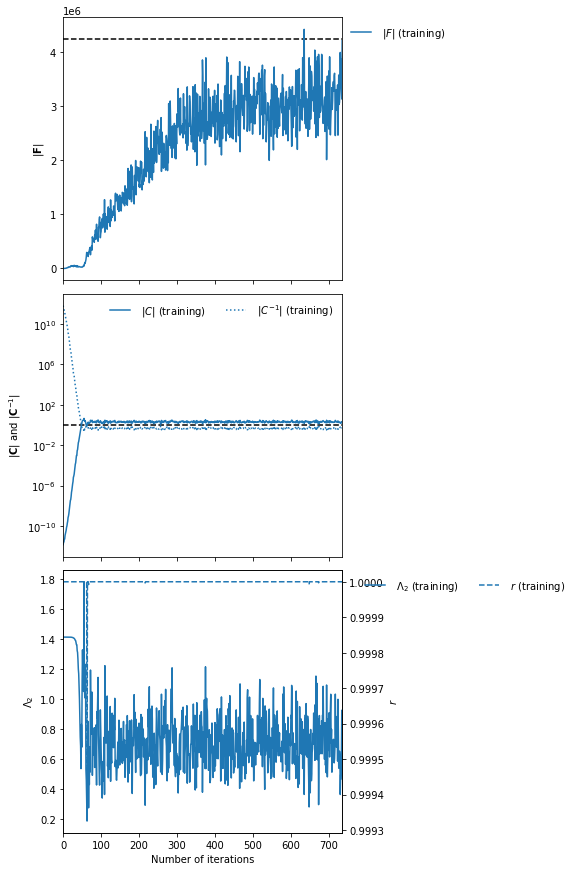

In [ ]:
ax = IMNN.plot(expected_detF=np.linalg.det(F));
#ax[0].set_yscale('log')

In [40]:
np.linalg.det(IMNN.F), IMNN.F

(DeviceArray(3388368.5, dtype=float32),
 DeviceArray([[3243.7693  ,  -61.736397],
              [ -61.736397, 1045.7526  ]], dtype=float32))

In [41]:
np.linalg.det(IMNN.F) / np.linalg.det(F)

DeviceArray(0.79816103, dtype=float32)

In [61]:
np.linalg.det(IMNN.F) / np.linalg.det(F)

DeviceArray(0.6681083, dtype=float32)

In [51]:
np.linalg.det(F)

DeviceArray(4245219., dtype=float32)

compute the Shannon entropy (in nats)

In [63]:
0.5*np.log(np.linalg.det(IMNN.F)), 0.5*np.log(np.linalg.det(F))

(DeviceArray(7.4304514, dtype=float32), DeviceArray(7.630652, dtype=float32))

# load the model weights !

In [64]:
# pickle the dictionary 
import cloudpickle as pickle
import os

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [65]:
cd /home/makinen/repositories/cosmicFields

/home/makinen/repositories/cosmicFields


In [55]:
#save_obj(IMNN.w, 'IMNN_w_gauss')
#save_obj(IMNN.history, 'IMNN_history_gauss')

In [62]:
trained_w = load_obj('IMNN_w_gauss')

IMNN.set_F_statistics(w=trained_w, key=rng)
IMNN.F

DeviceArray([[3160.6533 , -203.61607],
             [-203.61607,  913.0941 ]], dtype=float32)

In [66]:
0.5*np.log(np.linalg.det(IMNN.F)), 0.5*np.log(np.linalg.det(F))

(DeviceArray(7.4304514, dtype=float32), DeviceArray(7.630652, dtype=float32))

# Inference

Here we'll generate a target observation on which to perform parameter inference



In [67]:
datakey = jax.random.PRNGKey(55)

In [163]:
datakey = jax.random.PRNGKey(66)

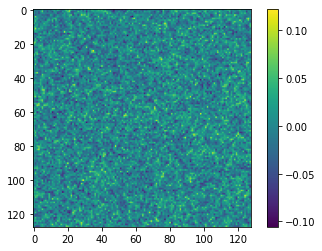

In [164]:
θ_target = np.array([0.95, 0.6])

#rng, key = jax.random.split(rng)
δ_target = simulator(datakey, θ_target, simulator_args=simulator_args)
plt.imshow(δ_target)
plt.colorbar();

In [165]:
#!pip install --upgrade tfp-nightly==0.15.0.dev20211116

create prior for inference

In [166]:
prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.8, 0.4], [1.2, 0.75])])
prior.low = np.array([0.8, 0.4])
prior.high = np.array([1.2, 0.75])

# compute exact analytic posterior

In [160]:
def log_likelihood(A, B, Δ, N):
    Δ = Δ[:N//2, :N].flatten()
    dlength = len(Δ)
    def fn(_A, _B):
        #if simulator_args["L_scale"]:
        pk = lambda k: P(k, A=_A, B=_B) / simulator_args["L"]
        pb = pbj.PowerBox(
          N=simulator_args["N"],                     # Number of grid-points in the box
          dim=simulator_args["dim"],                     # 2D box
          pk = pk, # The power-spectrum
          boxlength = simulator_args["L"],           # Size of the box (sets the units of k in pk)
          key = rng,                # Use the same seed as our powerbox
          vol_normalised_power=True,
          supplied_freqs=simulator_args['freqs']
        )
        powers = pk(pb.k())
        C = powers[:N//2, :N].flatten()
        invC = 1. / C
        exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
        norm = -0.5 * np.sum(np.log(C)) -0.5 * len(Δ) * np.log(np.pi * 2.)
        return (exponent + norm)
    return jax.vmap(fn)(A, B)

In [161]:
from powerbox_jax import dft # with correct fourier conventions

In [73]:
import imnn.lfi

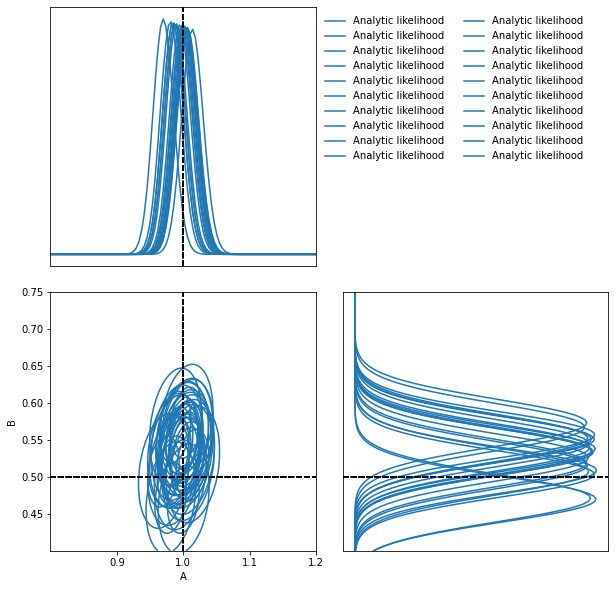

In [78]:
for i in range(20):
    key,rng = jax.random.split(key)
    _δ_target = simulator(key, θ_target, simulator_args=simulator_args)
    LFI = imnn.lfi.LikelihoodFreeInference(
        prior=prior,
        gridsize=100)
    A, B = np.meshgrid(*LFI.ranges)
    LFI.n_targets=1
    LFI.put_marginals(jax.nn.softmax(
                np.real(
                    log_likelihood(
                        A.ravel(),
                        B.ravel(),
                        dft.fft(_δ_target, L=pb.boxlength, freq=pb.freqs, left_edge=pb.left_edge,
                            a=pb.fourier_a, b=pb.fourier_b)[0] / L,
                        N))
                ).reshape((100, 100)).T[np.newaxis])
    if i==0:
        ax = LFI.marginal_plot(
            known=θ_target,
            label="Analytic likelihood",
            axis_labels=["A", "B"])
    else:
        LFI.marginal_plot(
            ax=ax,
            known=θ_target,
            label="Analytic likelihood",
            axis_labels=["A", "B"])

plt.show()

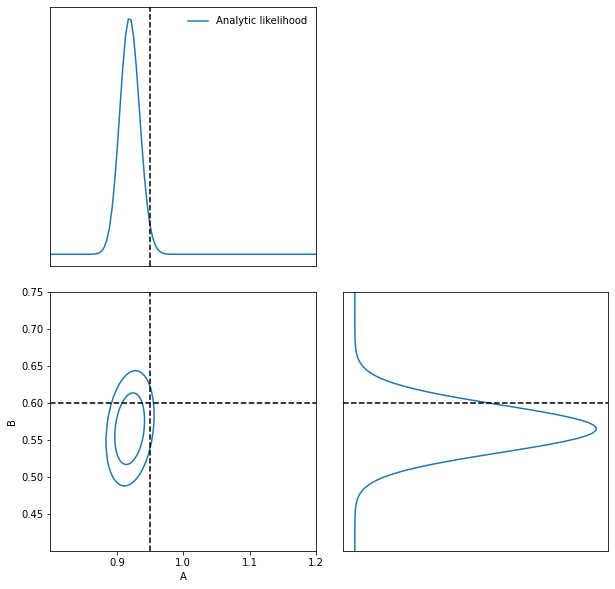

In [167]:
LFI = imnn.lfi.LikelihoodFreeInference(
    prior=prior,
    gridsize=100)
A, B = np.meshgrid(*LFI.ranges)
LFI.n_targets=1
LFI.put_marginals(jax.nn.softmax(
            np.real(
                log_likelihood(
                    A.ravel(),
                    B.ravel(),
                    dft.fft(δ_target, L=pb.boxlength, freq=pb.freqs, left_edge=pb.left_edge,
                           a=pb.fourier_a, b=pb.fourier_b)[0] / L,
                    N))
            ).reshape((100, 100)).T[np.newaxis]);
LFI.marginal_plot(
    known=θ_target,
    label="Analytic likelihood",
    axis_labels=["A", "B"]);

# Do a Gaussian Approximation with IMNN to the Posterior

In [168]:
# first get a score estimate for the parameters using the IMNN Fisher
IMNN.get_estimate(np.expand_dims(δ_target, (0, -1)))

DeviceArray([[0.9294965, 0.5423228]], dtype=float32)

In [169]:
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=IMNN.get_estimate(np.expand_dims(δ_target, (0, -1))), 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)

GA2 = imnn.lfi.GaussianApproximation(
    parameter_estimates=IMNN.get_estimate(np.expand_dims(δ_target, (0, -1))), 
    invF=np.expand_dims(np.linalg.inv(F), 0), 
    prior=prior, 
    gridsize=100)

# compare Fisher approximations to the field-level likelihood

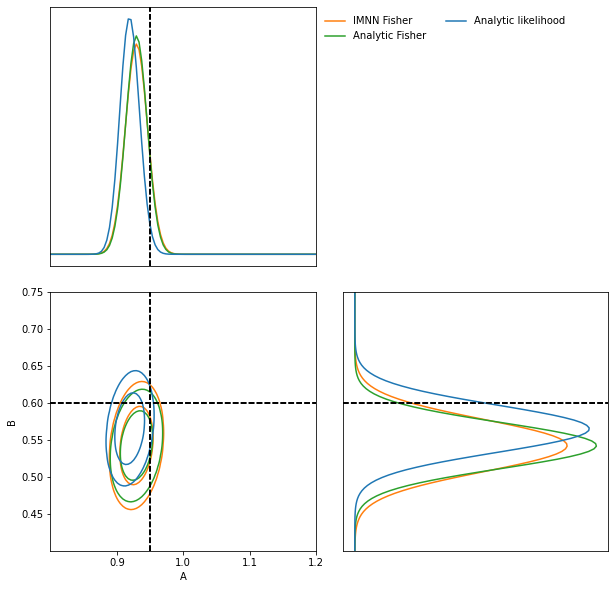

In [170]:
ax = GA.marginal_plot(
    known=θ_target,          
    label="IMNN Fisher",         
    axis_labels=[r"A", r"B"],
    colours="C1")

GA2.marginal_plot(
    ax = ax,
    known=θ_target,          
    label="Analytic Fisher",         
    axis_labels=[r"A", r"B"],
    colours="C2")

LFI.marginal_plot(
    ax = ax,
    known=θ_target,
    label="Analytic likelihood",
    axis_labels=["A", "B"]);

# and finally we can do an approximate Bayesian computation SBI

In [83]:
#@title ABC code
import jax
import jax.numpy as np
from imnn.lfi import LikelihoodFreeInference
from imnn.utils import container
from scipy.ndimage import gaussian_filter
from imnn.utils.utils import _check_input


class ApproximateBayesianComputation(LikelihoodFreeInference):
    """Approximate Bayesian computation

    Approximate Bayesian computation involves drawing parameter values from a
    prior, :math:`\\boldsymbol{\\theta}_i\\leftarrow p(\\boldsymbol{\\theta})`,
    and generating simulations at this value using a model,
    :math:`{\\bf d}_i = f(\\boldsymbol{\\theta}_i)`, which can then be
    compressed down to some informative summary,
    :math:`{\\bf x}_i =g({\\bf d}_i)`. By compressing some observed target to
    get :math:`{\\bf x}^\\textrm{obs} =g({\\bf d}^\\textrm{obs})` we can
    simulate from the prior distribution of possible parameter values to create
    a set of summaries :math:`\\{{\\bf x}_i|i\\in[1, n_\\textrm{sims}]\\}`. The
    approximate posterior distribution is then obtained as the samples of
    parameter values whose summaries of simulations have an infinitely small
    difference from the summary of the target observation:

    .. math::

        p(\\boldsymbol{\\theta}|{\\bf d}^\\textrm{obs})\\approx
        \\{\\boldsymbol{\\theta}_i|
        i~\\textrm{where}~\\lim_{\\epsilon\\to0}
        D(g(f(\\boldsymbol{\\theta}_i), g({\\bf d}^\\textrm{obs}))<\\epsilon\\}

    Note that the distance measure :math:`D(x, y)` is somewhat ambiguous, but
    in the infinitessimal limit will be more or less flat. Sensible choices for
    this distance measure can be made, i.e. for parameter estimates a Fisher
    scaled squared distance, but it is not wholly trivial in all cases.

    This class contains several methods for making simulations, compressing
    them and doing distance based acceptance and rejection of the parameters
    used to make the simulations from the compressed summaries of target data.
    In particular either a single set of simulations can be run and the
    distance calculated, simulations can be run until a desired number of
    accepted points within achosen distance are obtained or if there are
    already a set of run simulations, different distance values can be chosen
    for acceptance and rejection of points. There are also several plotting
    methods for corner plots.

    Note that if the summaries of the data are not parameter estimates then the
    distance measure must be optimal for the summary space to make sense.

    Parameters
    ----------
    target_summaries : float(n_targets, n_summaries)
        The compressed data to be infered
    n_summaries : int
        The size of the output of the compressor for a single simulation
    n_targets : int
        The number of different targets to be infered
    F : float(n_params, n_params)
        The Fisher information matrix for rescaling distance measure
    parameters : utils container
        Holds accepted and rejected parameters and some summaries of results
    summaries : utils container
        Holds accepted and rejected summaries and some summaries of results
    distances : utils container
        Holds accepted and rejected distances of summaries to targets and
        some summaries of results

    Methods
    -------
    simulator
        A simulator which takes in an array of parameters and returns
        simulations made at those parameter values
    compressor
        A function which takes in an array of simulations and compresses them.
        If no compression is needed this can be an identity function
    distance_measure:
        Either ``F_distance`` or ``euclidean_distance`` depending on inputs
    """
    def __init__(self, target_data, prior, simulator, compressor,
                 gridsize=100, F=None, distance_measure=None):
        """Constructor method

        Parameters
        ----------
        target_data: float(n_targets, input_data)
            Data (or batch of data) to infer parameter values at
        prior: fn
            A prior distribution which can be evaluated and sampled from
            (should also contain a ``low`` and a ``high`` attribute with
            appropriate ranges)
        simulator: fn
            A function which takes in a batch of parameter values (and random
            seeds) and returns a simulation made at each parameter value
        compressor: fn
            A function which takes a batch of simulations and returns their
            compressed summaries for each simulation (can be identity function
            for no compression)
        gridsize : int or list, default=100
            The number of grid points to evaluate the marginal distribution on
            for every parameter (int) or each parameter (list)
        F : list or float({n_targets}, n_params, n_params) or None
            The Fisher information matrix to rescale parameter directions for
            measuring the distance. If None, this is set to the identity matrix
        distance_measure : fn or None
            A distance measuring function between a batch of summaries and a
            single set of summaries for a target. If None, ``F_distance``
            (Euclidean scaled by the Fisher information) is used. This is only
        """
        super().__init__(
            prior=prior,
            gridsize=gridsize)
        self.simulator = simulator
        self.compressor = compressor
        if len(target_data.shape) == 1:
            target_data = np.expand_dims(target_data, 0)
        self.target_summaries = self.compressor(target_data)
        self.n_summaries = self.target_summaries.shape[-1]
        self.n_targets = self.target_summaries.shape[0]
        if F is not None:
            if self.n_summaries != self.n_params:
                raise ValueError(
                    "If using the Fisher information to scale the distance " +
                    "then the compressor must return parameter estimates. " +
                    "The compressor returns summaries with shape " +
                    f"{(self.n_summaries,)}, but should return estamites " +
                    f"with shape {(self.n_params)} if the prior is correct.")
            if isinstance(F, list):
                self.F = np.stack([
                    _check_input(f, (self.n_params, self.n_params), "F")
                    for f in F], 0)
            else:
                if F.shape == (self.n_params, self.n_params):
                    self.F = np.expand_dims(F, 0)
                    if self.n_targets > 1:
                        self.F = np.repeat(self.F, self.n_targets)
                else:
                    self.F = _check_input(
                        F, (self.n_targets, self.n_params, self.n_params), "F")
            self.distance_measure = self.F_distance

        if distance_measure is not None:
            self.distance_measure = distance_measure
        elif F is None:
            self.distance_measure = self.euclidean_distance
            self.F = np.zeros(self.n_targets)

        self.parameters = container()
        self.parameters.n_params = self.n_params
        self.summaries = container()
        self.summaries.n_summaries = self.n_summaries
        self.distances = container()
        self.distances.n_targets = self.n_targets

    def __call__(self, ϵ=None, rng=None, n_samples=None, parameters=None,
                 summaries=None, min_accepted=None, max_iterations=10,
                 smoothing=None, replace=False):
        """Run the ABC

        Parameters
        ----------
        ϵ : float or float(n_targets) or None, default=None
            The acceptance distance between summaries from simulations and the
            summary of the target data. A different epsilon can be passed for
            each target. If None (and `rng` and `n_samples` are not None) then
            samples are obtained but no acceptance and rejection takes place
        rng : int(2,) or None, default=None
            A random number generator for generating simulations and randomly
            drawing parameter values from the prior. Can be None if passing
            `parameters` and `summaries` to set prerun simulations or if `ϵ`
            is not None for resetting the accepted parameters and summaries
        n_samples : int or None, default=None
            Number of simulations to make (or how many to make each iteration
            if `min_accepted` is not None). Can be None if passing `parameters`
            and `summaries` to set prerun simulations or if `ϵ` is not None for
            resetting the accepted parameters and summaries
        parameters : float(any, n_params) or None, default=None
            The pre-obtained parameter values to set to the class (`summaries`
            must not be None)
        summaries : float(any, n_summaries) or None, default=None
            The summaries of prerun simulations (at parameter values
            corresponding to the values in `parameters`) to set the class
            attributes
        min_accepted : int or None, default=None
            A minimum number of accepted samples desired within a chosen `ϵ`
            value. If None and `ϵ`, `rng`, `n_samples` are not None then just
            `n_samples` will be run
        max_iterations : int, default=10
            A maximum number of while loop iterations to run when getting a
            minimum number of accepted samples
        smoothing : float or None, default=None
            A Gaussian smoothing for the marginal distributions
        replace : bool, default=False
            Whether to replace the summaries, parameters and distances already
            obtained when running again

        Returns
        -------
        parameters container:
            All parameters with accepted and rejected attributes
        summaries container:
            All summaries with accepted and rejected attributes
        distances container:
            All distances with accepted and rejected attributes

        Todo
        ----
        type checking and pytests
        """
        if ((self.parameters.all is None)
                and ((rng is None) or (n_samples is None))
                and ((parameters is None) or (summaries is None))):
            raise ValueError(
                "No samples currently available. If running simulations " +
                "`rng` must be a JAX prng and `n_samples` an integer number " +
                "of samples. If using premade summaries `parameters` and " +
                "`summaries` must be numpy arrays.")
        if ((min_accepted is not None) and (ϵ is None)):
            raise ValueError("`ϵ` must be passed if passing `min_accepted`")
        if (rng is not None) and (n_samples is not None):
            if ((ϵ is not None) and (min_accepted is not None)):
                self.set_samples(
                    *self.get_min_accepted(
                        rng=rng, ϵ=ϵ, accepted=min_accepted,
                        n_simulations=n_samples,
                        max_iterations=max_iterations),
                    replace=True)
            else:
                self.set_samples(
                    *self.get_samples(rng=rng, n_samples=n_samples),
                    replace=replace)
        if (parameters is not None) and (summaries is not None):
            self.set_samples(parameters, summaries, replace=replace)
        if ϵ is not None:
            self.set_accepted(ϵ, smoothing=smoothing)
        return self.parameters, self.distances, self.summaries

    def set_samples(self, parameters, summaries, distances=None,
                    replace=False):
        """Fills containers and calculates distances

        All parameters and summaries of simulations made at those parameters
        (and their distance from the summary of the observed data) are kept in
        containers for ease of use. This function sets the ``all`` attribute of
        these containers with the passed summaries and parameters (and
        distances if provided or it calculates the distances). These are
        concatenated to existing values unless ``replace = True`` in which the
        existing values are removed and overwritten with the passed summaries,
        parameters and distances.

        Parameters
        ----------
        parameters : float(any, n_params)
            The pre-obtained parameter values to set to the class
        summaries : float(any, n_summaries)
            The summaries of prerun simulations (at parameter values
            corresponding to the values in `parameters`)
        distances : float(n_targets, any) or None, default=None
            The distances of the summaries from the summaries of each target.
            If None then the distances will be calculated
        replace : bool, default=False
            Whether to replace the summaries, parameters and distances already
            obtained
        """
        if distances is None:
            distances = jax.vmap(
                lambda target, F: self.distance_measure(
                    summaries, target, F))(self.target_summaries, self.F)
        if (self.parameters.all is None) or (replace):
            self.parameters.all = parameters
            self.summaries.all = summaries
            self.distances.all = distances
        else:
            self.parameters.all = np.concatenate(
                [self.parameters.all, parameters], axis=0)
            self.summaries.all = np.concatenate(
                [self.summaries.all, summaries], axis=0)
            self.distances.all = np.concatenate(
                [self.distances.all, distances], axis=0)
        self.parameters.size = self.parameters.all.shape[0]
        self.summaries.size = self.summaries.all.shape[0]
        self.distances.size = self.distances.all.shape[-1]

    def get_samples(self, rng, n_samples, dist=None):
        """Draws parameters from prior and makes and compresses simulations

        Simulations are done `n_samples` in parallel

        Parameters
        ----------
        rng : int(2,)
            A random number generator to draw the parameters and make
            simulations with
        n_samples : int
            Number of parallel samples to draw
        dist : fn or None, default=None
            A distribution to sample, if None the samples will be drawn from
            the prior set in the class initialisation
        """
        rng, key = jax.random.split(rng)
        if dist is None:
            parameters = self.prior.sample(n_samples, seed=rng)
        else:
            parameters = dist.sample(n_samples, seed=rng)
        summaries = self.compressor(self.simulator(key, parameters))
        return parameters, summaries

    def set_accepted(self, ϵ, smoothing=None):
        """Sets the accepted and rejected attributes of the containers

        Using a distance (or list of distances for each target) cutoff between
        simulation summaries and summaries from some target the accepted and
        rejected parameter values (and summaries) can be defined. These points
        are used to make an approximate set of marginal distributions for
        plotting based on histogramming the points - where smoothing can be
        performed on the histogram to avoid undersampling artefacts.

        Parameters
        ----------
        ϵ : float or float(n_targets)
            The acceptance distance between summaries from simulations and the
            summary of the target data. A different epsilon can be passed for
            each target.
        smoothing : float or None, default=None
            A Gaussian smoothing for the marginal distributions

        Methods
        -------
        get_accepted:
            Returns a boolean array with whether summaries are within `ϵ`
        """
        def get_accepted(distances, ϵ):
            """ Returns a boolean array with whether summaries are within `ϵ`

            Parameters
            ----------
            distances : float(any)
                The distances between the summary of a target and the summaries
                of the run simulations
            ϵ : float
                The acceptance distance between summaries from simulations and
                the summary of the target data
            """
            return np.less(distances, ϵ)

        if not isinstance(ϵ, list):
            accepted = jax.vmap(
                lambda distances: get_accepted(distances, ϵ))(
                self.distances.all)
        else:
            accepted = jax.vmap(get_accepted)(self.distances.all, ϵ)

        rejected = ~accepted
        accepted_inds = [np.argwhere(accept)[:, 0] for accept in accepted]
        rejected_inds = [np.argwhere(reject)[:, 0] for reject in rejected]
        self.parameters.ϵ = ϵ
        self.summaries.ϵ = ϵ
        self.distances.ϵ = ϵ
        self.parameters.accepted = [self.parameters.all[inds]
                                    for inds in accepted_inds]
        self.parameters.n_accepted = np.array([
            self.parameters.accepted[i].shape[0]
            for i in range(self.n_targets)])
        self.summaries.accepted = [self.summaries.all[inds]
                                   for inds in accepted_inds]
        self.summaries.n_accepted = np.array([
            self.summaries.accepted[i].shape[0]
            for i in range(self.n_targets)])
        self.distances.accepted = [
            self.distances.all[i, inds]
            for i, inds in enumerate(accepted_inds)]
        self.distances.n_accepted = np.array([
            self.distances.accepted[i].shape[0]
            for i in range(self.n_targets)])
        self.parameters.rejected = [
            self.parameters.all[inds] for inds in rejected_inds]
        self.summaries.rejected = [
            self.summaries.all[inds] for inds in rejected_inds]
        self.distances.rejected = [
            self.distances.all[i, inds]
            for i, inds in enumerate(rejected_inds)]
        self.marginals = self.get_marginals(smoothing=smoothing)

    def get_min_accepted(self, rng, ϵ, accepted, n_simulations=1,
                         max_iterations=10, smoothing=None, verbose=True):
        """Iteratively run ABC until a minimum number of samples are accepted

        Setting a maximum distance that simulation summaries can be allowed to
        be from the summaries of each target an iterative scheme can be used to
        get ``n_samples`` simulations at a time, compress them and calculate
        the distances until the minimum number of desired samples are within
        the allowed cutoff distance. If multiple targets are being inferred
        then the simulations are run until all targets have at least the
        minimum number of accepted samples.

        Parameters
        ----------
        rng : int(2,)
            A random number generator to draw the parameters and make
            simulations with
        ϵ : float or float(n_targets)
            The acceptance distance between summaries from simulations and the
            summary of the target data. A different epsilon can be passed for
            each target.
        accepted : int
            The minimum number of samples to be accepted within the `ϵ` cutoff
        n_simulations : int, default=1
            The number of simulations to do at once
        max_iterations : int, default=10
            Maximum number of iterations in the while loop to prevent infinite
            runs. Note if max_iterations is reached then there are probably
            not the required number of accepted samples
        smoothing : float or None, default=None
            A Gaussian smoothing for the marginal distributions
        verbose : bool, default=True
            Whether to print out the running stats (number accepted,
            iterations, etc)

        Returns
        -------
        float(any, n_params)
            All parameters values drawn
        float(any, n_summaries)
            All summaries of simulations made
        float(n_target, any)
            The distance of every summary to each target
        """
        @jax.jit
        def loop(inputs):
            return jax.lax.while_loop(loop_cond, loop_body, inputs)

        def loop_cond(inputs):
            return np.logical_and(
                np.less(np.min(inputs[-2]), accepted),
                np.less(inputs[-1], max_iterations))

        def loop_body(inputs):
            rng, parameters, summaries, distances, n_accepted, iteration = \
                inputs
            rng, key = jax.random.split(rng)
            parameter_samples = self.prior.sample(n_simulations, seed=key)
            rng, key = jax.random.split(rng)
            summary_samples = self.compressor(
                self.simulator(key, parameter_samples))
            distance_samples = jax.vmap(
                lambda target, F: self.distance_measure(
                    summary_samples, target, F))(
                self.target_summaries, self.F)
            indices = jax.lax.dynamic_slice(
                np.arange(n_simulations * max_iterations),
                [n_simulations * iteration],
                [n_simulations])
            parameters = parameters.at[indices].set(parameter_samples)
            summaries = summaries.at[indices].set(summary_samples)
            distances = distances.at[:, indices].set(distance_samples)
            n_accepted = np.int32(np.less(distances, ϵ).sum(1))
            return rng, parameters, summaries, distances, n_accepted, \
                iteration + np.int32(1)

        parameters = np.ones((max_iterations * n_simulations, self.n_params))
        summaries = np.ones(
            (max_iterations * n_simulations,
             self.n_summaries))
        distances = np.ones((
            self.n_targets,
            max_iterations * n_simulations)) * np.inf
        if self.parameters.all is not None:
            parameters = np.vstack([parameters, self.parameters.all])
            summaries = np.vstack([summaries, self.summaries.all])
            distances = np.hstack([distances, self.distances.all])
            if self.parameters.n_accepted is None:
                self.set_accepted(ϵ, smoothing=smoothing)
            n_accepted = np.int32(self.parameters.n_accepted)
        else:
            n_accepted = np.zeros(self.n_targets, dtype=np.int32)
        current_accepted = n_accepted
        iteration = 0
        _, parameters, summaries, distances, n_accepted, iteration = loop(
            (rng, parameters, summaries, distances, n_accepted, iteration))
        keep = ~np.any(np.isinf(distances), 0)
        parameters = parameters[keep]
        summaries = summaries[keep]
        distances = distances[:, keep]
        if verbose:
            print(f"{n_accepted - current_accepted} accepted in last ",
                  f"{iteration} iterations ",
                  f"({n_simulations * iteration} simulations done).")
        return parameters, summaries, distances

    def set_marginals(self, accepted_parameters=None, ranges=None,
                      gridsize=None, smoothing=None):
        """Wrapper for ``get_marginals`` to set the ``marginals`` attribute

        Parameters
        ----------
        accepted_parameters : float(any, n_params) or None, default=None
            An array of all accepted parameter values
        ranges : list or None, default=None
            A list of arrays containing the bin centres for the marginal
            distribution obtained by histogramming for each parameter.
        gridsize : list or None, default=None
            The number of grid points to evaluate the marginal distribution on
            for each parameter
        smoothing : float or None, default=None
            A Gaussian smoothing for the marginal distributions
        """
        self.marginals = self.get_marginals(
            accepted_parameters=accepted_parameters, ranges=ranges,
            gridsize=gridsize, smoothing=smoothing)

    def get_marginals(self, accepted_parameters=None, ranges=None,
                      gridsize=None, smoothing=None):
        """ Creates the 1D and 2D marginal distribution list for plotting

        Using list of parameter values (accepted by the ABC) an approximate set
        of marginal distributions for plotting are created based on
        histogramming the points. Smoothing can be performed on the histogram
        to avoid undersampling artefacts.

        For every parameter the full distribution is summed over every other
        parameter to get the 1D marginals and for every combination the 2D
        marginals are calculated by summing over the remaining parameters. The
        list is made up of a list of n_params lists which contain n_columns
        number of objects.

        Parameters
        ----------
        accepted_parameters : float(any, n_params) or None, default=None
            An array of all accepted parameter values. If None, the accepted
            parameters from the `parameters` class attribute are used
        ranges : list or None, default=None
            A list of arrays containing the bin centres for the marginal
            distribution obtained by histogramming for each parameter. If None
            the ranges are constructed from the ranges of the prior
            distribution.
        gridsize : list or None, default=None
            The number of grid points to evaluate the marginal distribution on
            for each parameter. This needs to be set if ranges is passed (and
            different from the gridsize set on initialisation)
        smoothing : float or None, default=None
            A Gaussian smoothing for the marginal distributions. Smoothing not
            done if smoothing is None

        Returns
        -------
        list of lists:
            The 1D and 2D marginal distributions for each parameter (of pair)
        """
        if accepted_parameters is None:
            accepted_parameters = self.parameters.accepted
        if ranges is None:
            ranges = [
                np.hstack([range, np.array([range[1] - range[0]])])
                - (range[1] - range[0]) / 2 for range in self.ranges]
        if gridsize is None:
            gridsize = self.gridsize
        if smoothing is not None:
            def smooth(x):
                return gaussian_filter(x, smoothing, mode="mirror")
        else:
            def smooth(x):
                return x
        marginals = []
        for row in range(self.n_params):
            marginals.append([])
            for column in range(self.n_params):
                if column == row:
                    marginals[row].append(
                        np.array([
                            smooth(np.histogram(
                                parameters[:, column],
                                bins=ranges[column],
                                density=True)[0])
                            for parameters in accepted_parameters]))
                elif column < row:
                    marginals[row].append(
                        np.array([
                            smooth(np.histogramdd(
                                parameters[:, [column, row]],
                                bins=[ranges[column], ranges[row]],
                                density=True)[0])
                            for parameters in accepted_parameters]))
        return marginals

    def scatter_plot(self, ax=None, ranges=None, points=None, label=None,
                     axis_labels=None, colours=None, hist=True, s=5, alpha=1.,
                     figsize=(10, 10), linestyle="solid", target=None, ncol=2,
                     bbox_to_anchor=(0.0, 1.0)):
        """Plot a scatter corner plot of all accepted parameter pair values

        Plots scatter plots for parameter values in 2D subplots (and optionally
        the histogram of points in the 1D diagonal subplots).

        Parameters
        ----------
        ax : list of matplotlib axes or None, default=None
            If ax is None a new figure and axes are created to make a corner
            plot otherwise a set of axes are formatted correctly for a corner
            plot. If existing ax is not correctly shaped there will be an error
        ranges : list, default=None
            The list of ranges to set the number of rows and columns (if this
            is None the ranges set on initialisation will be used)
        points : float(n_targets, n_points, {n_params} or {n_summaries})
            The points to scatter plot, if None the class instance of
            `parameters.accepted` will be used
        label : str or None, default=None
            Name to be used in the legend
        axis_labels : list of str or None, default=None
            A list of names for each parameter, no axis labels if None
        colours : str or list or None, default=None
            The colour or list of colours to use for the different targets, if
            None then the normal matplotlib colours are used
        hist : bool, default=True
            Whether or not to plot histograms on the diagonal of the corner
            plot
        s : float, default=5.
            The size of the marker points in the scatter plot
        alpha : float, default=1.
            The amount of alpha colour for the marker points
        figsize : tuple, default=(10, 10)
            The size (in inches) to create a figure (if ax is None)
        linestyle : str, default="solid"
            Linestyle for the histograms
        target : None or int or list, default=None
            The indices to choose which target's points are plotted
        format : bool, default=False
            If formatting is not needed
        ncols : int, default=2
            Number of columns for the legend
        bbox_to_anchor : tuple, default=(0.0, 1.0)
            Position to fix the legend to

        Returns
        -------
        axes object:
            The scatter plot axes
        """
        if ranges is None:
            ranges = self.ranges
        if points is None:
            points = self.parameters.accepted
        return self._scatter_plot(
            ax=ax, ranges=ranges, points=points, label=label,
            axis_labels=axis_labels, colours=colours, hist=hist, s=s,
            alpha=alpha, figsize=figsize, linestyle=linestyle, target=target,
            ncol=ncol, bbox_to_anchor=bbox_to_anchor)

    def scatter_summaries(self, ax=None, ranges=None, points=None, label=None,
                          axis_labels=None, colours=None, hist=True, s=5,
                          alpha=1., figsize=(10, 10), linestyle="solid",
                          gridsize=100, target=None, format=False, ncol=2,
                          bbox_to_anchor=(0.0, 1.0)):
        """Plot a scatter corner plot of all accepted summary pair values

        Plots scatter plots for summary values in 2D subplots (and optionally
        the histogram of points in the 1D diagonal subplots).

        Parameters
        ----------
        ax : list of matplotlib axes or None, default=None
            If ax is None a new figure and axes are created to make a corner
            plot otherwise a set of axes are formatted correctly for a corner
            plot. If existing ax is not correctly shaped there will be an error
        ranges : list, default=None
            The list of ranges to set the number of rows and columns (if this
            is None the ranges set on initialisation will be used)
        points : float(n_targets, n_points, {n_params} or {n_summaries})
            The points to scatter plot, if None the class instance of
            `summaries.accepted` will be used
        label : str or None, default=None
            Name to be used in the legend
        axis_labels : list of str or None, default=None
            A list of names for each parameter, no axis labels if None
        colours : str or list or None, default=None
            The colour or list of colours to use for the different targets, if
            None then the normal matplotlib colours are used
        hist : bool, default=True
            Whether or not to plot histograms on the diagonal of the corner
            plot
        s : float, default=5.
            The size of the marker points in the scatter plot
        alpha : float, default=1.
            The amount of alpha colour for the marker points
        figsize : tuple, default=(10, 10)
            The size (in inches) to create a figure (if ax is None)
        linestyle : str, default="solid"
            Linestyle for the histograms
        target : None or int or list, default=None
            The indices to choose which target's points are plotted
        format : bool, default=False
            If formatting is not needed
        ncols : int, default=2
            Number of columns for the legend
        bbox_to_anchor : tuple, default=(0.0, 1.0)
            Position to fix the legend to

        Returns
        -------
        axes object:
            The scatter plot axes

        Todo
        ----
        There are many extra matplotlib parameters which could be passed,
        although this is not done because the axis is returned which can then
        be manipulated.
        """
        if points is None:
            points = self.summaries.accepted
            n_summaries = self.n_summaries
        else:
            n_summaries = points[0].shape[-1]
        gridsize = self.get_gridsize(gridsize, n_summaries)
        targets, n_targets = self.target_choice(target)
        if ranges is None:
            ranges = [
                np.linspace(
                    np.min(
                        np.array([
                            np.min(points[target][:, summary])
                            for target in targets])),
                    np.max(
                        np.array([
                            np.max(points[target][:, summary])
                            for target in targets])),
                    gridsize[summary])
                for summary in range(n_summaries)]
        return self._scatter_plot(
            ax=ax, ranges=ranges, points=points, label=label,
            axis_labels=axis_labels, colours=colours, hist=hist, s=s,
            alpha=alpha, figsize=figsize, linestyle=linestyle, target=target,
            format=format, ncol=ncol, bbox_to_anchor=bbox_to_anchor)

    def F_distance(self, x, y, F):
        """Default distance measure, squared difference scaled by Fisher matrix

        The target summaries are expanded on the zeroth axis so that it can
        broadcast with the simulation summaries.

        Parameters
        ----------
        x : (any, n_params)
            Envisioned as a whole batch of summaries of simulations
        y : (n_params)
            Envisioned as a target summary
        F : (n_params)
            Fisher information matrix to scale the summary direction
        """
        difference = x - np.expand_dims(y, 0)
        return np.sqrt(
            np.einsum(
                "ik,kl,il->i",
                difference,
                F,
                difference))

    def euclidean_distance(self, x, y, aux=None):
        """Euclidean distance between simulation summaries and target summary

        The target summaries are expanded on the zeroth axis so that it can
        broadcast with the simulation summaries.

        Parameters
        ----------
        x : (any, n_params)
            Envisioned as a whole batch of summaries of simulations
        y : (n_params)
            Envisioned as a target summary
        aux : None, default=Note
            Empty holder so that function works in the same way as `F_distance`
        """
        difference = x - np.expand_dims(y, 0)
        return np.sqrt(np.sum(np.square(difference), -1))


In [48]:
δ_target.shape

(128, 128)

In [171]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(np.expand_dims(δ_target, 0), -1),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100,
    F=np.expand_dims(IMNN.F, 0))

In [ ]:
# %%time
# rng,abc_key = jax.random.split(rng)
# ABC(rng=abc_key,
#         n_samples=int(1e3),
#         min_accepted=15000,
#         max_iterations=50000,
#         ϵ=0.05,
#         smoothing=0.);

In [116]:
rng, key = jax.random.split(rng)
ABC(ϵ=0.1, rng=key, n_samples=1000, min_accepted=15000,
    smoothing=0., max_iterations=50000);

[6344] accepted in last  50000 iterations  (50000000 simulations done).


In [229]:
rng, key = jax.random.split(rng)
ABC(ϵ=0.5, rng=key, n_samples=1000, min_accepted=10000,
    smoothing=0, max_iterations=1000);

[2996] accepted in last  919 iterations  (919000 simulations done).


In [ ]:
ABC.distances.accepted

In [231]:
import numpy as onp

cutoff = 0.1

smallabc = onp.array(ABC.parameters.accepted[0][ABC.distances.accepted[0] < cutoff])
smalldists = onp.array(ABC.distances.accepted[0][ABC.distances.accepted[0] < cutoff])

smallabc.shape

(407, 2)

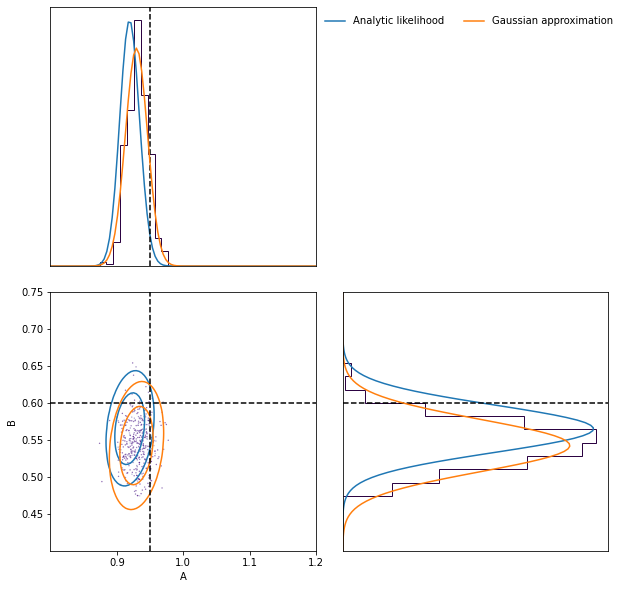

In [232]:
ax = LFI.marginal_plot(
    known=θ_target,
    label="Analytic likelihood",
    axis_labels=["A", "B"])


GA.marginal_plot(
    ax=ax,
    label="Gaussian approximation",
    colours="C1",
    axis_labels=["A", "B"])


# ABC.marginal_plot(
#     ax=ax,
#     label="Approximate Bayesian computation, $\epsilon = 0.5$",
#     colours="C2");

# ABC scatter plots
# just to fiddle with the label
ax[0,0].plot(0.3, 0., color=new_colors[0],
           marker='o', label='ABC')

ax[0,0].hist(smallabc[:, 0], color=new_colors[0], histtype='step', density=True)
ax[1,0].scatter(smallabc[:, 0], smallabc[:, 1], s=8, alpha=0.6,
                c=np.log(smalldists), cmap='Purples', edgecolors=None, linewidths=0, marker='.')

ax[1,1].hist(smallabc[:, 1], color=new_colors[0], 
             histtype='step', density=True, orientation='horizontal')

plt.show()

In [ ]:
np.save(ABC.parameters.accepted[0], 'abc_params')
np.save(ABC.distances.accepted[0], 'abc_distances')

In [143]:
smalldists.shape

(1598,)

In [144]:
import matplotlib

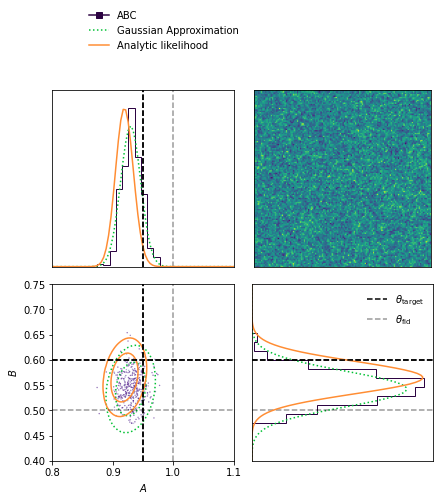

In [233]:
#%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
#fig = plt.figure(constrained_layout=True, figsize=(3.41*1., 3.41*1.))
#fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
#ax = fig.subplots(nrows=2, ncols=2)
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.41*2., 3.41*2.), 
                      gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[1,1]})
#latexify(fig_width=3.41, fig_height=3.41)

# just to fiddle with the label
ax[0,0].plot(0.3, 0., color=new_colors[0],
           marker='s', label='ABC')

cmap_reversed = matplotlib.cm.get_cmap('viridis_r')



ax = GA.marginal_plot(ax=ax, colours='#00c133', #new_colors[1], 
                          axis_labels=[r"$A$", r"$B$"], label="Gaussian Approximation", ncol=1,
                            linestyle='dotted')
ax[0,0].legend(framealpha=0.)
ax[0,1].imshow(np.squeeze(δ_target), cmap='viridis')


ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate

LFI.marginal_plot(
    ax=ax,
    known=θ_target,
    label="Analytic likelihood",
    ncol=1,
    colours='#FF8D33',
    axis_labels=["A", "B"]);

#ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label='Analytic Likelihood', linestyle='--')
#ax[0,0].legend(framealpha=0.)
#ax[0, 1].axis("off")
#ax[1, 0].contour(A_range, B_range, likelihood, levels=value, colors='#FF8D33', linestyles='--')
#ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='Analytic Likelihood', linestyle='--')



# ax = ABC.scatter_plot(ax=ax,
#                       colours=new_colors[0], 
#                       axis_labels=[r"$A$", r"$B$"], 
#                       s=8,
#                       label='ABC', bbox_to_anchor=None)

# ABC scatter plots
ax[0,0].hist(smallabc[:, 0], color=new_colors[0], histtype='step', density=True)
ax[1,0].scatter(smallabc[:, 0], smallabc[:, 1], s=8, alpha=0.6,
                c=np.log(smalldists), cmap='Purples', edgecolors=None, linewidths=0, marker='.')

ax[1,1].hist(smallabc[:, 1], color=new_colors[0], 
             histtype='step', density=True, orientation='horizontal')


#ax[1,0].legend(framealpha=0.)



ax[0,0].set_xlim(0.8, 1.1)
ax[0,0].set_ylim(0., 30.1)
ax[1,0].set_xlim(0.8, 1.1)
ax[1,0].set_ylim(0.4, 0.75)
ax[1,1].set_ylim(0.4, 0.75)

ax[0,0].legend(framealpha=0., bbox_to_anchor=(1.08, 1.5), frameon=False)


ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
#ax[0,0].set_ylabel(r'$\mathit{P}(A|\textbf{x})$')
#ax[1,1].set_xlabel(r'$\mathit{P}(B|\textbf{x})$')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()